In [24]:
import os
os.environ["http_proxy"] = "http://web-proxy.informatik.uni-bonn.de:3128"
os.environ["https_proxy"] = "http://web-proxy.informatik.uni-bonn.de:3128"

In [25]:
import argparse
import torch
import copy

from src.datasets import get_dataloader
from src.lightning import DDPM
from src.molecule_builder import get_bond_order
from src.visualizer import save_xyz_file
from tqdm.auto import tqdm
import sys #@mastro
from src import const #@mastro
import numpy as np #@mastro
from numpy.random import default_rng
from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import directed_hausdorff
import random
from sklearn.decomposition import PCA
from src.visualizer import load_molecule_xyz, load_xyz_files
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from src import const
import networkx as nx
import time 
import yaml
from pysmiles import read_smiles
import pickle

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

with open('config.yml', 'r') as file:
    config = yaml.safe_load(file)

checkpoint = config['CHECKPOINT']
chains = config['CHAINS']
DATA = config['DATA']
prefix = config['PREFIX']
keep_frames = int(config['KEEP_FRAMES'])
P = config['P']
device = config['DEVICE'] if torch.cuda.is_available() else 'cpu'
SEED = int(config['SEED'])
ROTATE = config['ROTATE']
TRANSLATE = config['TRANSLATE']
REFLECT = config['REFLECT']
TRANSFORMATION_SEED = int(config['TRANSFORMATION_SEED'])
SAVE_VISUALIZATION = config['SAVE_VISUALIZATION']
M = int(config['M'])
NUM_SAMPLES = int(config['NUM_SAMPLES'])
PARALLEL_STEPS = int(config['PARALLEL_STEPS'])

print("Random seed: ", SEED)

experiment_name = checkpoint.split('/')[-1].replace('.ckpt', '')

transformations = []
if ROTATE:
    transformations.append("rotate")
if TRANSLATE:
    transformations.append("translate")
if REFLECT:
    transformations.append("reflect")

transformations_str = "_".join(transformations) if transformations else "no_transform"
chains_output_dir = os.path.join(chains, experiment_name, prefix, f'chains_hausdorff_distance_{P}_seed_{SEED}_{transformations_str}_transformation_seed_{TRANSFORMATION_SEED}_COM_addition')
final_states_output_dir = os.path.join(chains, experiment_name, prefix, f'final_states_hausdorff_distance_{P}_seed_{SEED}_{transformations_str}_transformation_seed_{TRANSFORMATION_SEED}_COM_addition')

print("Applied trasformations: ", transformations_str)
print("Seed used for random transformations (if applied): ", TRANSFORMATION_SEED)

os.makedirs(chains_output_dir, exist_ok=True)
os.makedirs(final_states_output_dir, exist_ok=True)

# Loading model form checkpoint (all hparams will be automatically set)
model = DDPM.load_from_checkpoint(checkpoint, map_location=device)

# Possibility to evaluate on different datasets (e.g., on CASF instead of ZINC)
model.val_data_prefix = prefix

print(f"Running device: {device}")
# In case <Anonymous> will run my model or vice versa
if DATA is not None:
    model.data_path = DATA

model = model.eval().to(device)
model.setup(stage='val')
dataloader = get_dataloader(
    model.val_dataset,
    batch_size=1
)

Random seed:  42
Applied trasformations:  no_transform
Seed used for random transformations (if applied):  42


/home/mastropietro/anaconda3/envs/diff_explainer/lib/python3.10/site-packages/lightning_fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
Lightning automatically

Running device: cuda:5


In [26]:
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
np.random.seed(SEED)
random.seed(SEED)

#### Similarity functions

In [27]:
def compute_molecular_similarity(mol1, mol2, mask1 = None, mask2 = None):
    """
    Compute the similarity between two molecules based on distances and atom type.
    
    Args:
        mol1 (torch.Tensor): The first molecule.
        mol2 (torch.Tensor): The second molecule.
        mask (torch.Tensor, optional): A mask indicating which atoms to consider. If not provided, all atoms will be considered.
        
    Returns:
        float: The similarity between the two molecules.
    """
    # If fragmen_mask is provided, only consider the atoms in the mask
    if mask1 is not None:
        mask1 = mask1.bool()
        mol1 = mol1[mask1,:]

    if mask2 is not None:
        mask2 = mask2.bool()
        mol2 = mol2[mask2,:]

    return 1 - torch.norm(mol1 - mol2)

def compute_molecular_distance(mol1, mol2, mask1 = None, mask2 = None):
    """
    Compute the similarity between two molecules based on distances and atom type.
    
    Args:
        mol1 (torch.Tensor): The first molecule.
        mol2 (torch.Tensor): The second molecule.
        mask (torch.Tensor, optional): A mask indicating which atoms to consider. If not provided, all atoms will be considered.
        
    Returns:
        float: The similarity between the two molecules.
    """
    # If fragmen_mask is provided, only consider the atoms in the mask
    if mask1 is not None:
        mask1 = mask1.bool()
        mol1 = mol1[mask1,:]

    if mask2 is not None:
        mask2 = mask2.bool()
        mol2 = mol2[mask2,:]

    return torch.norm(mol1 - mol2).item()

def compute_molecular_distance_batch(mol1, mol2, mask1 = None, mask2 = None):
    """
    Compute the similarity between two molecules based on distances and atom type.
    
    Args:
        mol1 (torch.Tensor): The first molecule.
        mol2 (torch.Tensor): The second molecule.
        mask (torch.Tensor, optional): A mask indicating which atoms to consider. If not provided, all atoms will be considered.
        
    Returns:
        torch.Tensor: The similarity between the two molecules for each element in the batch.
    """
    # If fragment_mask is provided, only consider the atoms in the mask
    if mask1 is not None:
        mask1 = mask1.bool()
        batch_size = mol1.shape[0]
        masked_mol1 = []
        for i in range(batch_size):
            masked_mol1.append(mol1[i, mask1[i], :])

        if batch_size == 1:
            mol1 = masked_mol1[0].unsqueeze(0)
        else:    
            mol1 = torch.stack(masked_mol1)
           
    if mask2 is not None:
        mask2 = mask2.bool()
        batch_size = mol2.shape[0]
        masked_mol2 = []
        for i in range(batch_size):
            masked_mol2.append(mol2[i, mask2[i], :])
        
        if batch_size == 1:
            mol2 = masked_mol2[0].unsqueeze(0)
        else:    
            mol2 = torch.stack(masked_mol2)

    return torch.norm(mol1 - mol2, dim=(1,2))

def compute_cosine_similarity(mol1, mol2, mask1 = None, mask2 = None):
    """
    Compute the similarity between two molecules based on distances and atom type.
    
    Args:
        mol1 (torch.Tensor): The first molecule.
        mol2 (torch.Tensor): The second molecule.
        mask (torch.Tensor, optional): A mask indicating which atoms to consider. If not provided, all atoms will be considered.
        
    Returns:
        float: The similarity between the two molecules.
    """
    # If fragmen_mask is provided, only consider the atoms in the mask
    if mask1 is not None:
        mask1 = mask1.bool()
        mol1 = mol1[mask1,:]

    if mask2 is not None:
        mask2 = mask2.bool()
        mol2 = mol2[mask2,:]

    return cosine_similarity(mol1.flatten().reshape(1, -1), mol2.flatten().reshape(1, -1)).item()


def compute_cosine_similarity_batch(mol1, mol2, mask1 = None, mask2 = None):
    """
    Compute the similarity between two molecules based on distances and atom type.
    
    Args:
        mol1 (torch.Tensor): The first molecule.
        mol2 (torch.Tensor): The second molecule.
        mask (torch.Tensor, optional): A mask indicating which atoms to consider. If not provided, all atoms will be considered.
        
    Returns:
        float: The similarity between the two molecules.
    """
    # If fragmen_mask is provided, only consider the atoms in the mask
    if mask1 is not None:
        mask1 = mask1.bool()
        batch_size = mol1.shape[0]
        masked_mol1 = []
        for i in range(batch_size):
            masked_mol1.append(mol1[i, mask1[i], :])
        
        if batch_size == 1:
            mol1 = masked_mol1[0].unsqueeze(0)
        else:    
            mol1 = torch.stack(masked_mol1)
        

    if mask2 is not None:
        mask2 = mask2.bool()
        mask2 = mask2.bool()
        batch_size = mol2.shape[0]
        masked_mol2 = []
        for i in range(batch_size):
            masked_mol2.append(mol2[i, mask2[i], :])
        
        if batch_size == 1:
            mol2 = masked_mol2[0].unsqueeze(0)
        else:    
            mol2 = torch.stack(masked_mol2)

    cos_sims = []
    for i in range(mol1.shape[0]):
        cos_sims.append(cosine_similarity(mol1[i].flatten().reshape(1, -1), mol2[i].flatten().reshape(1, -1)).item())

    return cos_sims

def compute_molecular_similarity_positions(mol1, mol2, mask1 = None, mask2 = None):
    """
    Compute the similarity between two molecules based on positions.
    
    Args:
        mol1 (torch.Tensor): The first molecule.
        mol2 (torch.Tensor): The second molecule.
        mask (torch.Tensor, optional): A mask indicating which atoms to consider. If not provided, all atoms will be considered.
        
    Returns:
        float: The similarity between the two molecules.
    """
    # If fragmen_mask is provided, only consider the atoms in the mask
    positions1 = mol1[:, :3].squeeze()
    positions2 = mol2[:, :3].squeeze()

    if mask1 is not None:
        mask1 = mask1.bool()
        positions1 = positions1[mask1,:]

    if mask2 is not None:
        mask2 = mask2.bool()
        positions2 = positions2[mask2,:]


    return 1 - torch.norm(positions1 - positions2) #choose if distance or similarity, need to check what it the better choice

def compute_one_hot_similarity(mol1, mol2, mask1 = None, mask2 = None):
    """
    Computes the similarity between two one-hot encoded molecules. The one-hot encoding indicates the atom type
    
    Args:
        mol1 (torch.Tensor): The first one-hot encoded molecule.
        mol2 (torch.Tensor): The second one-hot encoded molecule.
        mask (torch.Tensor, optional): A mask to apply on the atoms. Defaults to None.
    
    Returns:
        torch.Tensor: The similarity between the two molecules.
    """
    
    # Apply mask if provided
    if mask1 is not None:
        mask1 = mask1.bool()
        mol1 = mol1[mask1,:]

    if mask2 is not None:
        mask2 = mask2.bool()
        mol2 = mol2[mask2,:]
    
    # Compute similarity by comparing the one-hot encoded features
    similarity = torch.sum(mol1[:,3:-1] == mol2[:,3:-1]) / mol1[:, 3:-1].numel()
    
    return similarity

def compute_hausdorff_distance_batch(mol1, mol2, mask1 = None, mask2 = None):
    """
    Compute the similarity between two molecules based on distances and atom type.
    
    Args:
        mol1 (torch.Tensor): The first molecule.
        mol2 (torch.Tensor): The second molecule.
        mask1 (torch.Tensor, optional): A mask indicating which atoms to consider for mo1. If not provided, all atoms will be considered.
        mask2 (torch.Tensor, optional): A mask indicating which atoms to consider for mol2. If not provided, all atoms will be considered.
        
    Returns:
        torch.Tensor: The similarity between the two molecules for each element in the batch.
    """
    # If fragment_mask is provided, only consider the atoms in the mask

    #take only the positions
    mol1 = mol1[:, :, :3]
    mol2 = mol2[:, :, :3]
    
    
    if mask1 is not None:
        mask1 = mask1.bool()
        batch_size = mol1.shape[0]
        masked_mol1 = []
        for i in range(batch_size):
            masked_mol1.append(mol1[i, mask1[i], :])
        
        if batch_size == 1:
            mol1 = masked_mol1[0].unsqueeze(0)
        else:    
            mol1 = torch.stack(masked_mol1)
        

    if mask2 is not None:
        mask2 = mask2.bool()
        mask2 = mask2.bool()
        batch_size = mol2.shape[0]
        masked_mol2 = []
        for i in range(batch_size):
            masked_mol2.append(mol2[i, mask2[i], :])
        
        if batch_size == 1:
            mol2 = masked_mol2[0].unsqueeze(0)
        else:    
            mol2 = torch.stack(masked_mol2)

    hausdorff_distances = []
    for i in range(mol1.shape[0]):
        hausdorff_distances.append(max(directed_hausdorff(mol1[i], mol2[i])[0], directed_hausdorff(mol2[i], mol1[i])[0]))

    return hausdorff_distances


def create_edge_index(mol, weighted=False):
    """
    Create edge index for a molecule.
    """
    adj = nx.to_scipy_sparse_array(mol).todense()
    row = torch.from_numpy(adj.row.astype(np.int64)).to(torch.long)
    col = torch.from_numpy(adj.col.astype(np.int64)).to(torch.long)
    edge_index = torch.stack([row, col], dim=0)

    if weighted:
        weights = torch.from_numpy(adj.data.astype(np.float32))
        edge_weight = torch.FloatTensor(weights)
        return edge_index, edge_weight

    return edge_index

def arrestomomentum():
    raise KeyboardInterrupt("Debug interrupt.")

## Explainability

### Utility function for visualization purposes

In [5]:
def draw_sphere_xai(ax, x, y, z, size, color, alpha):
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)

    xs = size * np.outer(np.cos(u), np.sin(v))
    ys = size * np.outer(np.sin(u), np.sin(v)) #* 0.8
    zs = size * np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x + xs, y + ys, z + zs, rstride=2, cstride=2, color=color, alpha=alpha)

def plot_molecule_xai(ax, positions, atom_type, alpha, spheres_3d, hex_bg_color, is_geom, fragment_mask=None, phi_values=None):
    x = positions[:, 0]
    y = positions[:, 1]
    z = positions[:, 2]
    # Hydrogen, Carbon, Nitrogen, Oxygen, Flourine

    idx2atom = const.GEOM_IDX2ATOM if is_geom else const.IDX2ATOM

    colors_dic = np.array(const.COLORS)
    radius_dic = np.array(const.RADII)
    area_dic = 1500 * radius_dic ** 2

    areas = area_dic[atom_type]
    radii = radius_dic[atom_type]
    colors = colors_dic[atom_type]

    if fragment_mask is None:
        fragment_mask = torch.ones(len(x))

    for i in range(len(x)):
        for j in range(i + 1, len(x)):
            p1 = np.array([x[i], y[i], z[i]])
            p2 = np.array([x[j], y[j], z[j]])
            dist = np.sqrt(np.sum((p1 - p2) ** 2))
            atom1, atom2 = idx2atom[atom_type[i]], idx2atom[atom_type[j]]
            draw_edge_int = get_bond_order(atom1, atom2, dist)
            line_width = (3 - 2) * 2 * 2
            draw_edge = draw_edge_int > 0
            if draw_edge:
                if draw_edge_int == 4:
                    linewidth_factor = 1.5
                else:
                    linewidth_factor = 1
                linewidth_factor *= 0.5
                ax.plot(
                    [x[i], x[j]], [y[i], y[j]], [z[i], z[j]],
                    linewidth=line_width * linewidth_factor * 2,
                    c=hex_bg_color,
                    alpha=alpha
                )

    

    if spheres_3d:
        
        for i, j, k, s, c, f, phi in zip(x, y, z, radii, colors, fragment_mask, phi_values):
            if f == 1:
                alpha = 1.0
                if phi > 0:
                    c = 'red'

            draw_sphere_xai(ax, i.item(), j.item(), k.item(), 0.5 * s, c, alpha)

    else:
        phi_values_array = np.array(list(phi_values.values()))

        #draw fragments
        fragment_mask_on_cpu = fragment_mask.cpu().numpy()
        colors_fragment = colors[fragment_mask_on_cpu == 1]
        x_fragment = x[fragment_mask_on_cpu == 1]
        y_fragment = y[fragment_mask_on_cpu == 1]
        z_fragment = z[fragment_mask_on_cpu == 1]
        areas_fragment = areas[fragment_mask_on_cpu == 1]
        
        # Calculate the gradient colors based on phi values
        cmap = plt.cm.get_cmap('coolwarm_r') #reversed heatmap for distance-based importance
        norm = plt.Normalize(vmin=min(phi_values_array), vmax=max(phi_values_array))
        colors_fragment_shadow = cmap(norm(phi_values_array))
        
        # ax.scatter(x_fragment, y_fragment, z_fragment, s=areas_fragment, alpha=0.9 * alpha, c=colors_fragment)

        ax.scatter(x_fragment, y_fragment, z_fragment, s=areas_fragment, alpha=0.9 * alpha, c=colors_fragment, edgecolors=colors_fragment_shadow, linewidths=5, rasterized=False)

        #draw non-fragment atoms
        colors = colors[fragment_mask_on_cpu == 0]
        x = x[fragment_mask_on_cpu == 0]
        y = y[fragment_mask_on_cpu == 0]
        z = z[fragment_mask_on_cpu == 0]
        areas = areas[fragment_mask_on_cpu == 0]
        ax.scatter(x, y, z, s=areas, alpha=0.9 * alpha, c=colors, rasterized=False)


def plot_data3d_xai(positions, atom_type, is_geom, camera_elev=0, camera_azim=0, save_path=None, spheres_3d=False,
                bg='black', alpha=1., fragment_mask=None, phi_values=None):
    black = (0, 0, 0)
    white = (1, 1, 1)
    hex_bg_color = '#FFFFFF' if bg == 'black' else '#000000' #'#666666'

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    ax.set_aspect('auto')
    ax.view_init(elev=camera_elev, azim=camera_azim)
    if bg == 'black':
        ax.set_facecolor(black)
    else:
        ax.set_facecolor(white)
    ax.xaxis.pane.set_alpha(0)
    ax.yaxis.pane.set_alpha(0)
    ax.zaxis.pane.set_alpha(0)
    ax._axis3don = False

    if bg == 'black':
        ax.w_xaxis.line.set_color("black")
    else:
        ax.w_xaxis.line.set_color("white")

    plot_molecule_xai(
        ax, positions, atom_type, alpha, spheres_3d, hex_bg_color, is_geom=is_geom, fragment_mask=fragment_mask, phi_values=phi_values
    )

    max_value = positions.abs().max().item()
    axis_lim = min(40, max(max_value / 1.5 + 0.3, 3.2))
    ax.set_xlim(-axis_lim, axis_lim)
    ax.set_ylim(-axis_lim, axis_lim)
    ax.set_zlim(-axis_lim, axis_lim)
    dpi = 300 if spheres_3d else 300 #it was 120 and 50

    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0.0, dpi=dpi)
        # plt.savefig(save_path, bbox_inches='tight', pad_inches=0.0, dpi=dpi, transparent=True)

        if spheres_3d:
            img = imageio.imread(save_path)
            img_brighter = np.clip(img * 1.4, 0, 255).astype('uint8')
            imageio.imsave(save_path, img_brighter)
    else:
        plt.show()
    plt.close()

def visualize_chain_xai(
        path, spheres_3d=False, bg="black", alpha=1.0, wandb=None, mode="chain", is_geom=False, fragment_mask=None, phi_values=None
):
    files = load_xyz_files(path)
    save_paths = []

    # Fit PCA to the final molecule – to obtain the best orientation for visualization
    positions, one_hot, charges = load_molecule_xyz(files[-1], is_geom=is_geom)
    pca = PCA(n_components=3)
    pca.fit(positions)

    for i in range(len(files)):
        file = files[i]

        positions, one_hot, charges = load_molecule_xyz(file, is_geom=is_geom)
        atom_type = torch.argmax(one_hot, dim=1).numpy()

        # Transform positions of each frame according to the best orientation of the last frame
        positions = pca.transform(positions)
        positions = torch.tensor(positions)

        fn = file[:-4] + '.png'
        plot_data3d_xai(
            positions, atom_type,
            save_path=fn,
            spheres_3d=spheres_3d,
            alpha=alpha,
            bg=bg,
            camera_elev=90,
            camera_azim=90,
            is_geom=is_geom,
            fragment_mask=fragment_mask,
            phi_values=phi_values
        )
        save_paths.append(fn)

    imgs = [imageio.imread(fn) for fn in save_paths]
    dirname = os.path.dirname(save_paths[0])
    gif_path = dirname + '/output.gif'
    imageio.mimsave(gif_path, imgs, subrectangles=True)

    if wandb is not None:
        wandb.log({mode: [wandb.Video(gif_path, caption=gif_path)]})

### Explainabiliy phase

##### Multiple sampling steps at a time

Loading initial distribution of noisy features and positions.


  0%|          | 0/30 [00:00<?, ?it/s]

Using P: 0.5


  0%|          | 0/21 [00:00<?, ?it/s]

['Cc1ccc(CCNC(=O)NCCc2csc(N3CCCC3)n2)c(C)c1']
V j plus hausdorff batches per atom: [[7.123731605911864, 1.501616531012274, 3.33862104417223, 0.17982095017092703, 6.283754097675869, 2.1756172881440636, 4.0930564760438, 6.133128890024063, 4.131294436565696, 0.38644278546911637, 2.0541836800072444, 5.523588494393632, 6.879993574424905, 1.6388639616187504, 6.407726619913584, 4.098660432419178, 3.120109258282614, 6.175044467873836, 7.5523959573704555, 2.9174070921217488, 1.509005005883749, 0.14740614828007717, 4.368097132702875, 0.3688905478961312, 0.42290907647240117, 0.060924840240038344, 0.12400047881038898, 4.797926007736707, 2.4227798304936474, 0.15719613057789952, 0.17677090585655575, 2.7320269283959355, 6.278798877761624, 1.5409248710748573, 0.1408961828471215, 2.0671559897013987, 0.13161154694372276, 5.302452221238503, 4.829096439470116, 4.923843051851717, 7.1365953948931296, 2.483384902961814, 7.478499316157983, 0.15924533911098573, 3.4310279922992932, 6.59383571870863, 7.250175717

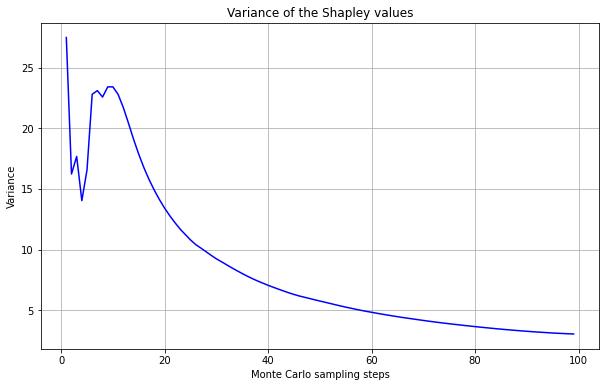

/tmp/ipykernel_1453838/1070884937.py:756: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /opt/conda/conda-bld/pytorch_1720538438429/work/aten/src/ATen/native/ReduceOps.cpp:1808.)
  sample_variances[i] = torch.var(torch.tensor(phi_sums_over_M[:i+1]), unbiased=True).item()


Using P: 0.5


  0%|          | 0/20 [00:00<?, ?it/s]

['Cc1ccc(CCNC(=O)NCCc2csc(N3CCCC3)n2)c(C)c1']
V j plus hausdorff batches per atom: [[1.2965516271157698, 2.031950768456771, 1.3285746753459178, 4.784993643903604, 1.1471218539596166, 2.895230508311549, 5.175362603343908, 4.871159525592774, 5.675396455569208, 2.1107616071834836, 4.561710044687051, 0.735510873830331, 4.2346974253894345, 4.141241323954554, 4.949514674813768, 8.90593404051732, 2.3380053657045683, 2.303096627648017, 3.8198146190632265, 2.2389953705292047, 1.816258873389012, 2.860525539814733, 1.8078388120090747, 6.8068059387938336, 0.660195482355238, 2.0377907358315044, 8.333613347498087, 5.401176761234454, 3.165750155317377, 2.0471564082048017, 1.7588899928282415, 1.762052933214917, 1.768429975649272, 2.665158018419339, 4.6600577247775306, 5.318901087108454, 8.175167298904851, 4.90401397853836, 2.096296066460426, 4.928059564148162, 6.039018098202928, 6.678003222932979, 8.14857518807513, 5.902716249415108, 1.8669118873388486, 7.020478558691381, 7.32777409600147, 8.542026055

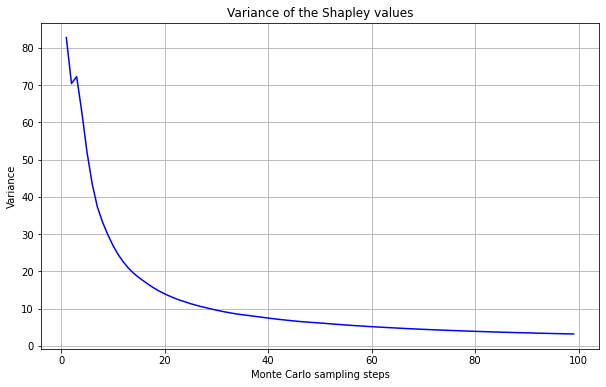

Using P: 0.5


  0%|          | 0/21 [00:00<?, ?it/s]

['Cc1ccc(CCNC(=O)NCCc2csc(N3CCCC3)n2)c(C)c1']
V j plus hausdorff batches per atom: [[6.688711888281723, 4.574396934586699, 2.4304237153628803, 6.689705586778504, 5.506799446353541, 4.553474464029475, 6.283240299904011, 3.530414334029011, 5.647165712396848, 5.638725094116803, 2.8808920239070113, 6.216097263380782, 2.840054868911464, 2.2079307439891833, 2.705183732072017, 5.694789881915775, 6.170479194543696, 4.560746527331722, 4.889702950354792, 5.1274728897140385, 4.792636859997527, 5.449935097954448, 4.77669988135702, 6.992703996401903, 4.3304903778769654, 5.613981579446776, 5.119639242131007, 5.452402127958009, 1.3718822399502266, 5.4827636709067775, 5.0899196106396865, 7.225717063782183, 3.420952080089097, 5.056699444036422, 5.227732052593284, 7.150191438991289, 4.247835917663731, 4.98421819774828, 5.449695373284458, 6.62904252719318, 5.747997373014832, 5.664780533356214, 3.577642248649957, 5.630070472488139, 3.654405404217254, 5.62010662636411, 5.279091636608644, 3.513420750091743,

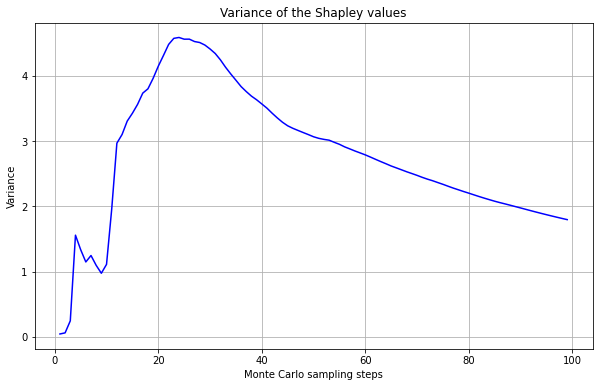

Using P: 0.5


  0%|          | 0/19 [00:00<?, ?it/s]

['Cc1ccc(CCNC(=O)NCCc2csc(N3CCCC3)n2)c(C)c1']
V j plus hausdorff batches per atom: [[3.815287581499318, 4.538522661530128, 3.700675361610913, 3.5891077403618743, 8.661944993565559, 4.959101153983181, 2.912575529425802, 3.302330668812349, 4.009982955221411, 5.1513584838633095, 4.6735126150194874, 4.218610563108833, 4.201881310425888, 4.104122129552861, 6.332354543634842, 4.211219413685435, 7.305751735290838, 3.706273729868079, 5.035271000058785, 4.6667515135275455, 4.441293998801984, 6.03701652142538, 3.8613990281192967, 1.6782075059418642, 2.335837856158438, 4.814820296891482, 5.506112310600814, 3.5598663566958395, 2.830183258729443, 7.784724648234616, 3.3799952250796745, 4.925433438995036, 3.944590880384119, 4.49933241281708, 5.596600613209093, 4.198037062549443, 3.3231813934563563, 2.698567241094632, 4.951454243010897, 4.460678751927383, 8.27565768321394, 6.989330449476219, 3.8231740409667236, 2.8343289545262764, 4.528744611643475, 4.01734967585022, 3.63542985063816, 5.27268503772996

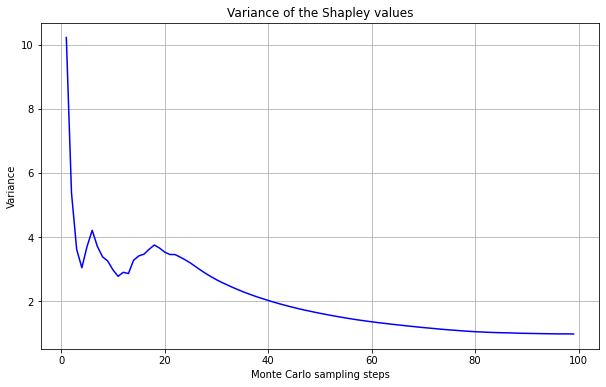

Using P: 0.5


  0%|          | 0/19 [00:00<?, ?it/s]

['Cc1ccc(CCNC(=O)NCCc2csc(N3CCCC3)n2)c(C)c1']
V j plus hausdorff batches per atom: [[5.959132537703044, 6.559633584647153, 4.614374390551604, 4.450323814704095, 6.073450841696294, 1.6146529152117581, 4.800667209905558, 6.78760834076957, 6.875554718482875, 4.937958216908588, 5.639404097209752, 8.438479020343982, 6.9620397090625294, 1.8698457887073539, 5.38514600473673, 7.360342898836514, 4.870708528396178, 1.6745510457821995, 5.568967819538089, 2.1230312612081836, 2.390781920168571, 1.9879938523648606, 3.8034178665837355, 6.263246611366458, 8.732623835176335, 6.820271860102327, 4.055338337998134, 4.591346667852274, 2.460145788943496, 4.583177145164177, 8.005682138497919, 8.671309342316588, 6.048905133987021, 3.815144935605529, 5.717010324790804, 5.026290162891554, 1.6859795397332553, 1.52728508083727, 7.24456329151521, 4.101361569645523, 1.5741705901366303, 8.158617456723794, 5.04696381578357, 1.2598452391441886, 2.5889421453770916, 5.82524706048843, 1.222352247993949, 3.023292052022918

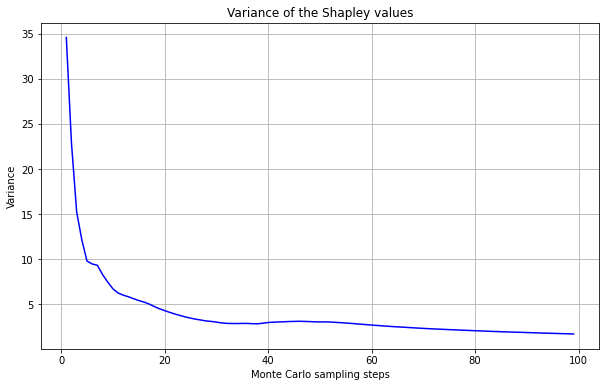

Using P: 0.5


  0%|          | 0/18 [00:00<?, ?it/s]

['Cc1ccc(CCNC(=O)NCCc2csc(N3CCCC3)n2)c(C)c1']
V j plus hausdorff batches per atom: [[3.4460176921518304, 2.1724378944768428, 3.560456367450296, 4.326321860798579, 4.650226000893289, 2.8697528477242655, 2.6654784490068004, 3.0922806468471187, 5.242857288293694, 3.5626577873354006, 6.9723515922060395, 7.868017914493701, 1.6569249504499444, 2.9184753989681345, 2.048925351898639, 4.327480375625577, 5.221794339532394, 4.396949909966625, 2.8843081992908126, 1.5835298775128364, 7.250073922739063, 4.243234387516552, 4.435367530929534, 3.5057995727241478, 4.588074608667475, 5.067028722795078, 5.207598699732912, 3.1836932813411214, 5.281986045612834, 4.482135162003121, 7.535640290023572, 3.382687974248507, 1.8777409269179302, 5.432359615937869, 2.775126546346652, 2.760121037951657, 3.1104790429032447, 5.221469170125891, 3.6520644334224603, 0.8496941501827505, 4.243276558710092, 5.509242169920083, 7.6692242199652405, 1.8275683020103703, 3.491018558621526, 1.534511056301211, 4.959539759458461, 5.2

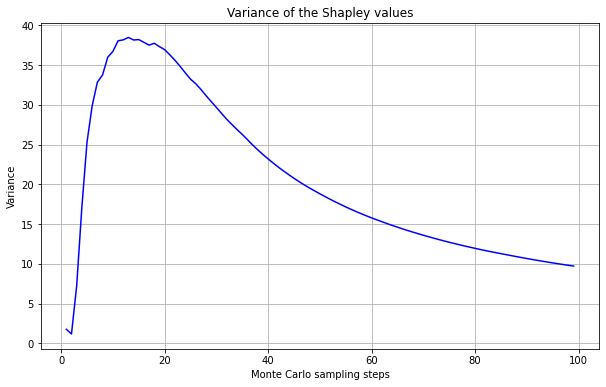

Using P: 0.5


  0%|          | 0/20 [00:00<?, ?it/s]

['Cc1ccc(CCNC(=O)NCCc2csc(N3CCCC3)n2)c(C)c1']
V j plus hausdorff batches per atom: [[6.290384109921224, 2.485993483555017, 7.5382391435242075, 5.74367042980594, 2.789577691031321, 3.980584191376757, 5.953787919273227, 5.5086110142986415, 2.5297447802980226, 3.690062665421657, 4.356551850866531, 3.5312115750245456, 2.738950501014793, 4.786526812566721, 2.242686322300917, 4.981775108528081, 3.5469874879891856, 7.281186248136885, 3.1925465372078587, 4.427774419789659, 4.365204468060066, 4.409866390618762, 2.711312752277392, 5.353741192409954, 6.748496017468543, 3.576422724458859, 1.6182962216829075, 6.4537337039609435, 7.114828260378419, 7.909392487468576, 7.909634548977131, 3.596788217599203, 8.234886378396258, 2.8748472501314652, 6.83187080852708, 6.927024324956017, 4.439826110151646, 3.322983251106312, 4.472031837641312, 2.720311463838922, 2.879513720435078, 1.9689976658172927, 4.801372836937531, 4.2613895383946865, 7.571158804563156, 3.723779130498594, 3.535096381393709, 8.10849584970

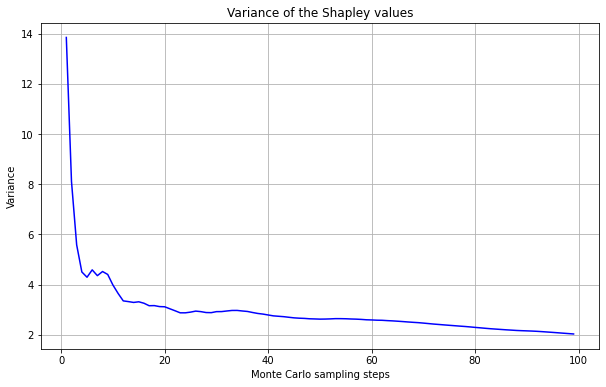

Using P: 0.5


  0%|          | 0/20 [00:00<?, ?it/s]

['Cc1ccc(CCNC(=O)NCCc2csc(N3CCCC3)n2)c(C)c1']
V j plus hausdorff batches per atom: [[5.076905381624931, 1.452121669341914, 4.247936073917682, 8.4857763291947, 1.8714983782514971, 4.0693289418422545, 1.4911804660490997, 7.271630908208034, 5.405072811095639, 1.672734187962381, 1.7161178012689098, 1.5663842618262358, 6.776882655680425, 3.068154231614123, 7.826724465012484, 8.85812115383947, 5.097696423870221, 2.202456219981267, 5.161783020529273, 3.799092818157331, 1.7451244748208605, 5.168594627316834, 5.188989381285695, 2.228328765296278, 4.6590577284791586, 2.7411955751286867, 8.174647781272851, 4.593683675840105, 1.5335858085732086, 5.735016593126505, 2.2703434173481924, 1.7741252583702831, 6.86933058056447, 3.4979271023926306, 4.632502656574297, 5.795232418944801, 3.2388579138940363, 4.824261144378687, 1.7078951212190743, 5.906533245931833, 1.5343819849692788, 5.327155501423332, 8.33006037456302, 9.299865325182669, 2.273512804103387, 2.3166376156239643, 1.631386666924535, 4.770782534

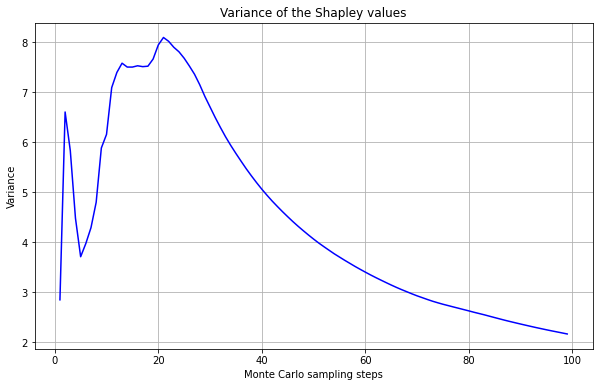

Using P: 0.5


  0%|          | 0/24 [00:00<?, ?it/s]

['O=C1CN(S(=O)(=O)c2cccc(NC(=O)c3cc(F)cc(F)c3)c2)CCN1']
V j plus hausdorff batches per atom: [[0.21756751943857894, 0.1543373766563146, 1.494397270340225, 1.2574738277552502, 3.334287578754576, 2.2992562546060453, 1.5640816207848913, 3.545742729889652, 1.382181316331096, 1.3809749222004617, 0.7734186797083741, 2.3710015319327997, 0.46512293100237345, 0.167327978636149, 1.7806142021356297, 0.2961245914248878, 2.1662442618724587, 3.2891270744919576, 1.479335125120848, 1.9933222221950957, 2.447953751882984, 0.42330362246138675, 2.055499954038917, 1.3963071389956676, 3.2324553838083885, 1.838381923238365, 1.7942426841602606, 2.1140876452701094, 3.8296479589858348, 2.557228481624939, 4.014586390497281, 2.006691224283793, 3.1003902431721406, 1.5077412913091108, 0.062329882799406204, 0.18449169857260614, 2.7731886507540535, 1.174352379153596, 3.1917260853840856, 3.198484851259087, 1.433193180936856, 1.724811320530754, 0.10709852755753221, 0.04692620958833643, 0.4138926670077289, 0.18075853754

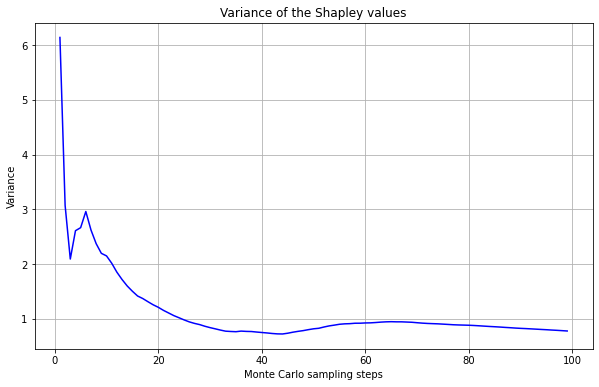

Using P: 0.5


  0%|          | 0/21 [00:00<?, ?it/s]

['O=C1CN(S(=O)(=O)c2cccc(NC(=O)c3cc(F)cc(F)c3)c2)CCN1']
V j plus hausdorff batches per atom: [[4.635235474711608, 3.304031031325657, 0.13304126079151943, 0.4140638213319063, 5.525377888093017, 1.9886879581410657, 6.230577252796501, 4.622074156086145, 0.3598148445489771, 0.5219207551086439, 0.20149330312356484, 0.474672762856262, 2.295796531599453, 0.3694588196248637, 4.763856903842847, 7.047671513019217, 1.6430120642334896, 3.6002902353633313, 0.8044853860459475, 6.483789983912275, 0.4080789529244684, 0.2779565220616649, 4.8357977108825665, 0.4746844672306022, 0.7246123715769531, 0.3695996027809548, 0.4779051235247089, 6.859668494604499, 6.521646866476829, 0.5508342143006231, 6.0972028433307806, 4.367701202069733, 0.2735033665463848, 0.3644801153797805, 0.19427851953935132, 2.6577253313528315, 0.5078667256495081, 7.863803932230606, 0.1536044341962775, 0.439894722245953, 6.562013804119558, 7.041664331064658, 6.691772313690801, 5.107492712345813, 3.232839843511456, 1.1219231003336845, 0.

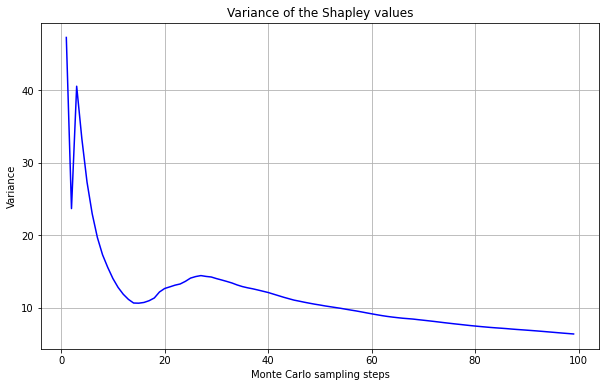

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.


Using P: 0.5


  0%|          | 0/15 [00:00<?, ?it/s]

['CCc1ccccc1NC(=O)C(=O)NC[C@H](C)C[C@@H](C)O']
V j plus hausdorff batches per atom: [[1.8508622533259171, 2.2280340381002395, 2.186138836055424, 2.51237449766502, 1.4029439649987034, 1.8713135047496567, 1.414806897894319, 2.481603487940497, 3.2362626923204103, 3.0381989559197056, 3.0509365748063986, 4.0649273488192, 3.199556304623288, 1.851613232924152, 2.1826868057271818, 1.5213088584030865, 2.7351942384419354, 3.148055597747724, 3.4016966602014542, 2.0062265440058678, 1.439533908274465, 2.773880929094864, 2.1740515315357767, 2.496776220615318, 2.63059161793399, 1.9004705979250525, 2.33826848182453, 1.6889957950036159, 2.086765526780725, 2.073029845796998, 1.9849403887526564, 2.8261003319060625, 2.0343468578584627, 2.641540777380243, 2.3542545901329084, 3.373016273936431, 1.3110227841812971, 2.33602033567526, 2.7514275733301066, 3.8150837791601484, 3.005695980571341, 3.2122162588195007, 1.2877565685883012, 1.8682183498703944, 1.9194203395918088, 3.2067836249642547, 2.9519117021542303,

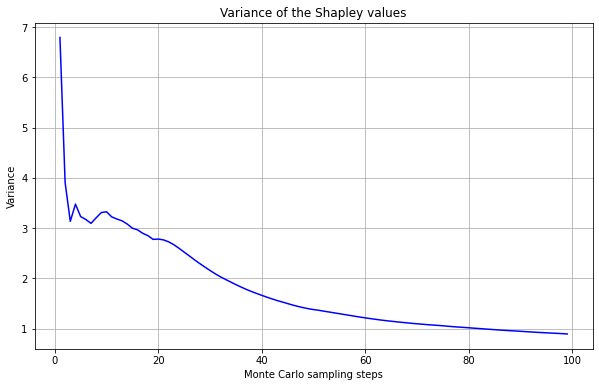

E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded


Using P: 0.5


  0%|          | 0/17 [00:00<?, ?it/s]

['Cc1ccc(C(C)C)c(OCC(=O)N/N=C/c2ccco2)c1']
V j plus hausdorff batches per atom: [[0.8322667282629052, 6.384271685995226, 4.8523141028406425, 4.725736053314826, 0.7238339201134976, 2.146881102875171, 3.923816106390158, 1.867808220532328, 4.021016037375824, 0.6554202115310023, 4.598072005609477, 0.7857003477115856, 1.2209403406823154, 1.034667317219648, 4.363144976268109, 8.827165390632995, 6.793267696435601, 0.9369344224516866, 0.927576072774826, 4.390866699955844, 4.359603175058161, 6.891468571166214, 4.263829960923031, 3.4914291647532263, 4.710509106294946, 4.478783282704656, 3.9514034549784514, 4.100026556154083, 4.421077317077095, 3.8551000617396256, 4.5907930776264445, 4.492810933163199, 1.1814989723650686, 2.0844480955101186, 0.3991058336784229, 2.0279775538085536, 0.8252732844331121, 3.8774439027584373, 4.328058039776696, 3.6342813793086717, 1.4091567074513327, 4.453150919582146, 1.4851029194800736, 0.7865962637756458, 4.298368571104673, 2.8463576297663016, 1.368490672351092, 2.9

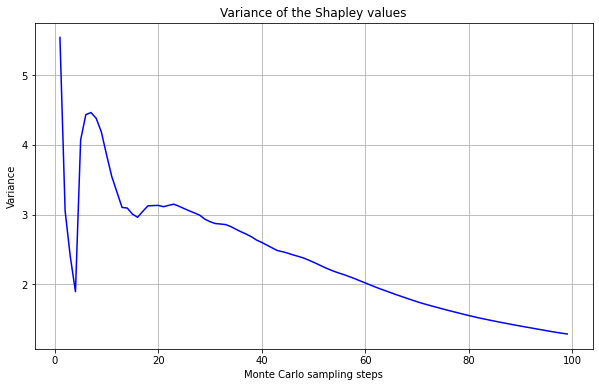

Using P: 0.5


  0%|          | 0/21 [00:00<?, ?it/s]

['Cc1ccc2c(c1)C(=O)N(CCC(=O)NCC(C1CC1)C1CC1)C2=O']
V j plus hausdorff batches per atom: [[0.21858364240733202, 5.451545364545894, 1.9757257381931217, 2.217444323413054, 2.4502318016937346, 7.128335106228053, 3.0185964412852386, 1.5037784848706814, 0.03954889878332796, 0.10003363700570808, 0.23550358289558113, 2.5470196783227586, 1.2995183657357192, 0.1741611526022375, 2.385926539677442, 1.8688106455561109, 3.121487608035952, 2.8961767284391073, 1.4450935412995236, 2.1244027912943357, 1.3896737621840665, 0.09423222293067882, 2.9384214459022786, 1.4506824264558131, 1.9371462998755393, 0.12317360283829795, 0.07715883148451563, 1.4569423991479316, 3.179631300068384, 0.03996933749352171, 0.03023470113664582, 3.4887214010452205, 4.5665931701382405, 0.049164855608950626, 0.3878799296661898, 1.524158341697411, 1.5170136383053425, 2.817085091168182, 1.0113732539161602, 0.09726675956491346, 2.608696870280575, 0.9293205468641986, 2.5728896422539833, 0.20091949038947957, 0.33091372370401884, 2.392

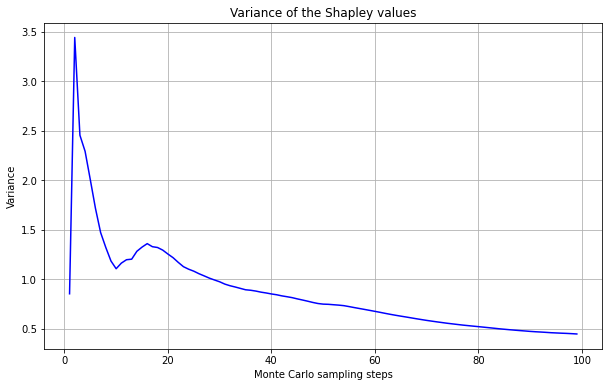

Using P: 0.5


  0%|          | 0/20 [00:00<?, ?it/s]

['Cc1ccc2c(c1)C(=O)N(CCC(=O)NCC(C1CC1)C1CC1)C2=O']
V j plus hausdorff batches per atom: [[1.4491547108902065, 3.428902552830383, 2.5708503550139117, 2.7864656084826716, 3.137449644739753, 1.83873542855171, 3.3594243473432592, 2.935638766957084, 2.44430005801435, 3.454400862347554, 3.5258193549868406, 4.242846878776585, 3.2062911827921368, 2.915254044342857, 2.592154627919217, 3.514807093612273, 3.5326493717236676, 3.524150562249322, 5.858737526518335, 3.362688311694162, 3.4137051461573393, 2.0790272995115884, 3.4991390094455075, 1.1822297690038086, 3.3803818175619003, 3.441800563116598, 2.4208119898139824, 2.9610797528082116, 3.4577441100288655, 2.346144752082917, 2.6397061377890343, 3.4978784329856656, 0.8045193551978402, 2.459575474970793, 3.5593398741878945, 3.618489144537911, 3.2742157562433096, 3.5652326051628163, 3.5522600778877496, 1.5685345172621297, 1.1768981705820514, 3.2566777187607685, 2.5338303929062316, 2.935758769680602, 3.054250633751473, 1.9856968477853454, 1.244918596

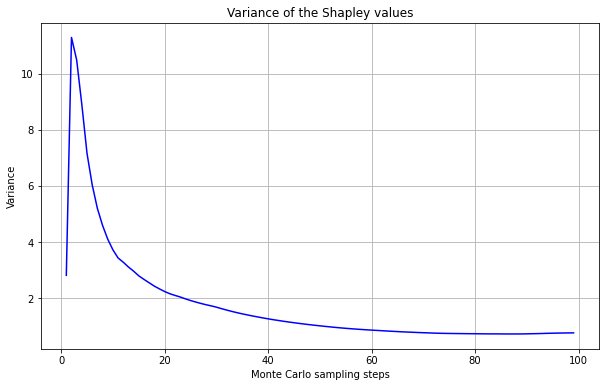

Using P: 0.5


  0%|          | 0/22 [00:00<?, ?it/s]

['Cc1ccc2c(c1)C(=O)N(CCC(=O)NCC(C1CC1)C1CC1)C2=O']
V j plus hausdorff batches per atom: [[0.006559762959912928, 2.552419112771118, 2.007547605223375, 0.1477277603575951, 0.09753573002573637, 4.049280385809388, 0.02251497280853487, 0.02696833307852237, 6.036031302511938, 2.3927446319112495, 0.24612155739881372, 0.06319125217950385, 1.5153373948687583, 0.1429275905431491, 7.067074276919144, 0.3962222923899837, 1.4929032967588538, 0.02015042840564518, 3.213761062321015, 0.1638395600095414, 3.154554103036465, 1.0091300793360816, 0.027791101178461532, 2.8225656327221627, 3.0302129294045432, 2.1799072752489543, 1.4875587011926983, 0.2854463190433902, 0.0671532204323636, 1.3687326561500288, 1.482797084206674, 0.13268004629165572, 3.653419791502288, 3.5666782631379257, 0.15863654734288524, 0.05957166849787661, 3.206177489047152, 0.018134638534330248, 0.26442775350620495, 0.02662468789190522, 3.629788760439128, 1.600169467698962, 1.4914302247512765, 1.4895451753009323, 3.373801983906368, 1.5326

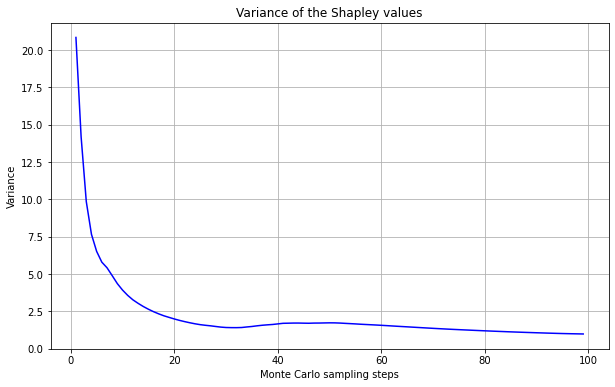

Using P: 0.5


  0%|          | 0/20 [00:00<?, ?it/s]

['Cc1ccc2c(c1)C(=O)N(CCC(=O)NCC(C1CC1)C1CC1)C2=O']
V j plus hausdorff batches per atom: [[3.1742658155461947, 0.07400491127060002, 3.0740567349932046, 0.0852198282910281, 0.059232405817803084, 0.3490082362853889, 1.382685413454836, 4.016964060695174, 0.410573314094924, 0.04307509823250242, 0.08829455921587263, 0.15595627358918418, 1.8308097325369361, 1.826475047471921, 1.7636688680643482, 1.4126274454819825, 0.11498038383634197, 0.2904633788063995, 2.2966393170477586, 0.0841062387568492, 0.06472949360652958, 1.0161126198131765, 0.058222813920158815, 1.766023171752256, 0.05234536012030627, 0.22249154117580366, 1.8338893804499175, 3.3806238111595466, 0.12107468290335033, 2.38766164334391, 3.2412718579491857, 0.03210583469944527, 1.322838713413008, 2.8407013068371163, 0.2374885870240509, 3.919023336613265, 0.1584916276877727, 2.409144233748546, 1.8017104887749915, 0.5781292240478975, 1.5112782983734199, 0.47459975987559994, 3.9631130381654596, 3.088060821682374, 1.6252615182357049, 1.7142

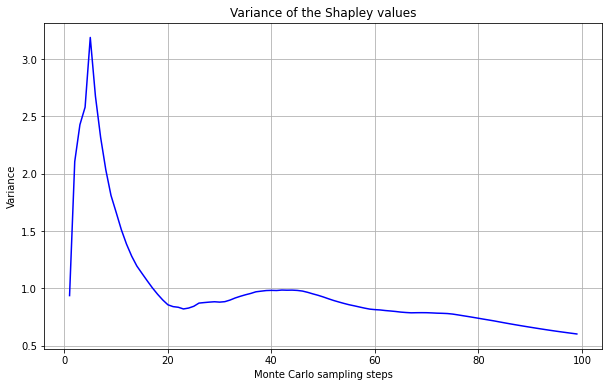

Using P: 0.5


  0%|          | 0/19 [00:00<?, ?it/s]

['Cc1ccc2c(c1)C(=O)N(CCC(=O)NCC(C1CC1)C1CC1)C2=O']
V j plus hausdorff batches per atom: [[2.248555714055083, 2.174763372254161, 1.3655262668203387, 3.513365393658999, 4.526324769936343, 2.974089928086281, 3.6959474417448943, 3.104568151782792, 3.98973443236738, 3.8923598175078213, 3.70995016563134, 3.674618500897233, 0.45189693012427457, 0.669564120818742, 3.7378457747226075, 0.9779429950433856, 3.7303361011758502, 2.3641555275111577, 1.3049833941537403, 1.830282900032925, 1.5560240591103556, 4.519484136321228, 2.2841446623145796, 1.6019867027548995, 3.224854398733225, 1.4755424895888873, 3.631637635940054, 3.0764259839983916, 1.9750372774123506, 1.9536801142819247, 3.7137203817920117, 1.9264621385446, 1.9878067814202802, 0.3265147287011598, 3.268984640807411, 3.974908533817004, 4.090566009406674, 0.6540461687159916, 4.733037871117343, 1.5445108135365264, 1.6390682799970777, 3.020606275460412, 2.058589548383762, 0.47316277637704346, 1.0669727843737606, 3.0855953415117474, 1.82716273555

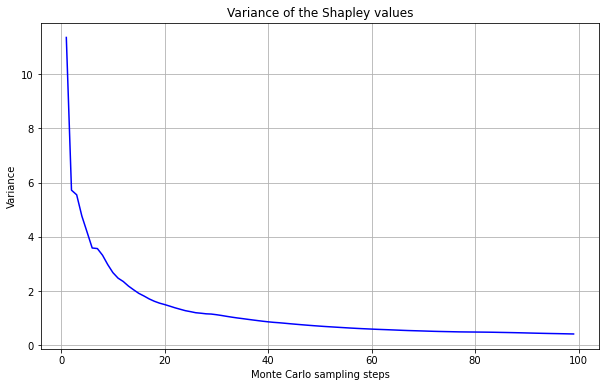

Using P: 0.5


  0%|          | 0/21 [00:00<?, ?it/s]

['Cc1ccc2c(c1)C(=O)N(CCC(=O)NCC(C1CC1)C1CC1)C2=O']
V j plus hausdorff batches per atom: [[1.607827039330421, 2.684422571064078, 1.7411609342275498, 1.6169689681598975, 2.8395011187771853, 2.5183315102046873, 3.3117197471016637, 3.7719448438490333, 0.06433640359365139, 1.3984619766776758, 4.0071221450702375, 4.1281477784497485, 1.3636243104115948, 1.561639429685271, 4.897779432645107, 2.113801157766884, 4.477373790002464, 4.25138720685009, 4.013426226792484, 4.130488865382317, 0.2449978287418411, 0.08281462206518417, 4.553725971079431, 1.2415052713341705, 2.786005739990027, 0.41899117395152824, 2.2855335567404103, 3.8814826916784306, 1.598464070746176, 0.0627006916851643, 0.26834223995206974, 2.694173169704303, 3.233059899433819, 0.13090590757285803, 0.14549200221373254, 1.9360874562822148, 1.655497592458421, 3.526463418665691, 1.4969587589318756, 0.38388154239983124, 1.92765519111154, 1.6329165165408026, 1.3913863895753524, 4.812088030039669, 3.383073306801466, 4.219467369055937, 2.526

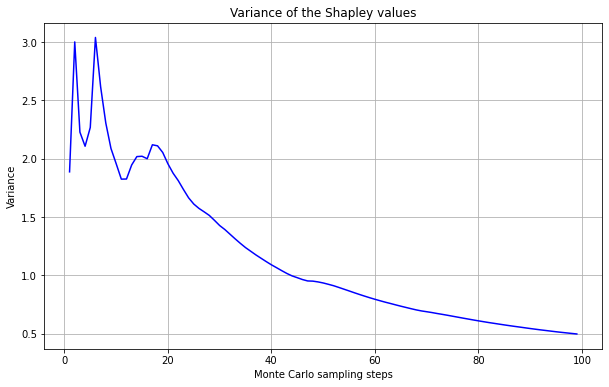

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.


Using P: 0.5


  0%|          | 0/17 [00:00<?, ?it/s]

['CC[C@H](NC(=O)[C@H]1CN(C)CCO1)c1ccc(Br)cc1']
V j plus hausdorff batches per atom: [[0.22788526502518042, 0.792003913506352, 1.6670506365628015, 0.40198838602588066, 0.7673076105484209, 1.69409601277732, 0.08163190874626954, 0.08817784027572843, 2.2837104418829814, 0.33999797118967684, 3.5455935782825754, 0.10735479879001739, 0.4471470446004347, 0.027484302150179295, 0.433213187908125, 3.4250712700800094, 4.250995751737764, 3.4970237194505143, 0.06426163380924646, 2.620394070634364, 0.6383579504765653, 0.15991534690947928, 4.423341190574756, 0.37241895946371667, 0.24444203629285255, 1.4707074275407572, 2.3907113090708014, 1.5302257609949166, 0.9084761808320744, 2.1755156323754106, 0.019117109226408746, 0.3860279053506801, 2.0922034657167123, 0.06281933183353462, 0.9233521543860302, 0.3732870678271829, 0.23969043791726857, 2.2429391698322587, 3.7492083877357256, 2.296845369833628, 3.56084412667353, 3.3204250324424778, 0.8709421589175635, 0.4734364203656241, 0.11533515104843178, 1.69553

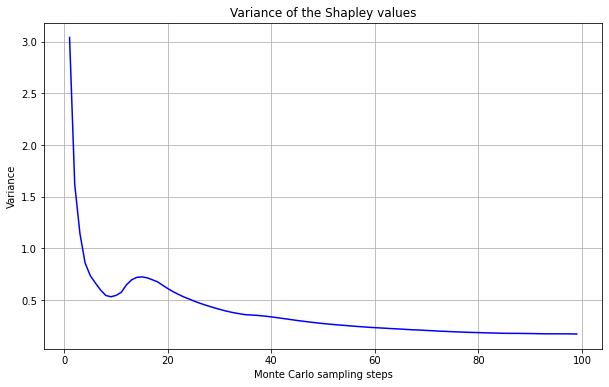

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.


Using P: 0.5


  0%|          | 0/14 [00:00<?, ?it/s]

['CC[C@H](NC(=O)[C@H]1CN(C)CCO1)c1ccc(Br)cc1']
V j plus hausdorff batches per atom: [[1.8698242665206806, 1.4889684096853915, 3.0959025788972814, 3.1443199269528437, 2.2934696773958314, 2.4799014655783376, 2.613133018247828, 3.759714676218579, 1.8716722756212352, 2.3715475873923837, 2.5409226853502274, 3.3106972571903968, 3.299844122527186, 2.605111120512473, 3.994049039835434, 2.2292866186058737, 2.7382695059343707, 3.9627405985519037, 2.7872280127661537, 3.7113342957421227, 2.407160160795189, 1.8384963022391954, 1.4574639301323304, 1.8451561712676376, 1.4225373860165984, 3.5767081609812204, 3.8609308902551027, 1.7899188049107495, 3.8621036521104006, 4.090088874686461, 2.576700429270937, 1.8715713406700967, 1.8011576113451402, 1.85008609859825, 3.148267680364073, 1.5017583888770611, 3.643093895863354, 3.3152324959156894, 1.650160157279611, 3.0772882981639014, 2.2724058914600844, 1.9651543518157297, 2.9762135356107167, 1.5486269619974555, 1.9251874763397159, 1.5876403045516827, 1.76478

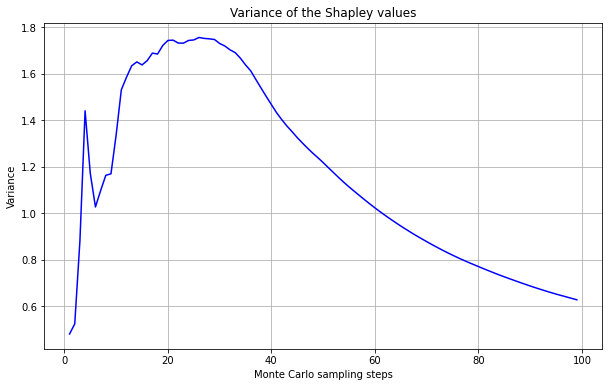

Using P: 0.5


  0%|          | 0/21 [00:00<?, ?it/s]

['CN(C)c1ccc(NC(=O)Cn2c(=O)[nH]c(=O)c3ccccc32)cn1']
V j plus hausdorff batches per atom: [[0.8033139822865839, 2.8813380968676507, 0.6325876173590332, 1.9433593951079327, 2.548472875683149, 3.2285954161703265, 0.9832188452136527, 1.3635353670584585, 0.5421824818096578, 0.09835499121636868, 5.000469146419308, 0.8707921632134367, 2.615649315133536, 0.11776265006154564, 4.138472029164047, 4.088902074493407, 3.9890891712776653, 1.8100559824467461, 2.396767590636773, 4.237266491207128, 0.13979242157673272, 0.10484859215227144, 2.386574537007083, 4.408338764302908, 2.533816080056241, 0.14934900769685894, 0.19189682897338534, 4.340908496982847, 0.6166918368937375, 0.0997417834401058, 0.07467347378161046, 1.854234125118248, 0.3464975050013545, 0.24787562001119343, 0.24077512094509224, 1.8853231087062636, 2.534671346845323, 0.18086578350088603, 0.378280639583346, 0.5615352035124571, 2.4815603179951142, 1.533881132949696, 2.4160631625889346, 1.644924381051671, 3.946873639366428, 1.33705902807288

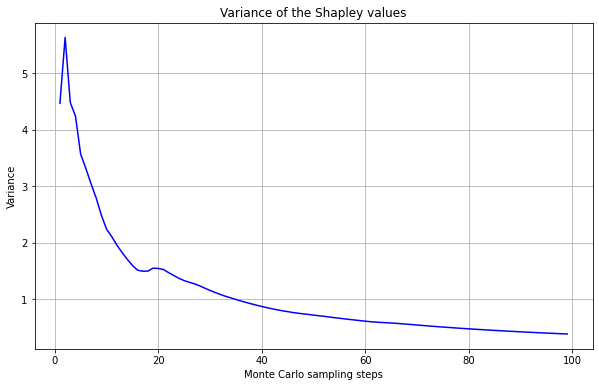

Using P: 0.5


  0%|          | 0/22 [00:00<?, ?it/s]

['CN(C)c1ccc(NC(=O)Cn2c(=O)[nH]c(=O)c3ccccc32)cn1']
V j plus hausdorff batches per atom: [[0.31904881858030265, 2.484293541319277, 2.387046805712316, 0.08652987218537711, 0.4869353628457509, 2.3828305938456094, 0.2966730341358331, 2.347689290266457, 2.856711364451407, 0.14384443817217796, 0.09438952498563893, 0.03623487796329313, 0.1764789414472547, 0.13110838926994053, 2.5154594658620897, 0.06800072444791216, 2.4624445823977923, 0.11352434224229535, 0.07161220757088144, 0.36038766018008317, 0.08264243125953344, 2.3224535385769474, 0.0833682260827305, 2.2923234646737964, 0.12395998003796573, 1.2922982634027358, 1.4722361428024435, 0.06144053150403101, 0.05904416855427089, 0.024607085601057597, 0.4059090996063659, 0.22727794788272715, 0.15971439890952413, 4.89180805236197, 0.7800476118654022, 1.4412566621722234, 2.097331787379883, 2.545951477938241, 0.12805196696580334, 0.09376779757989041, 3.0538355928418857, 0.2442364904573597, 2.582165867155828, 4.5155961382067815, 1.7262874796894758

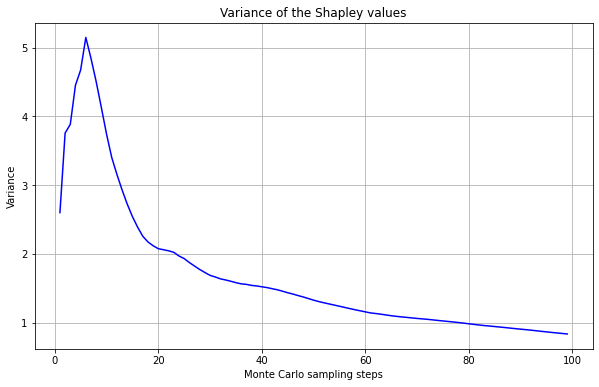

Atom "[C@H]" contains stereochemical information that will be discarded.


Using P: 0.5


  0%|          | 0/23 [00:00<?, ?it/s]

['Cc1ccc2nccc(C(=O)N3CCC[C@H](C(=O)c4cccc5ccccc45)C3)c2c1']
V j plus hausdorff batches per atom: [[3.2504106343847674, 1.2690698868070012, 1.5593772705244275, 2.1856374879989606, 1.37963066676949, 2.7115589758921517, 2.507751856075737, 5.529122718895689, 2.4617152303895296, 2.552235046881201, 1.7919465442404996, 5.330409323249122, 1.5495709971864775, 1.919814365095535, 7.938921968011389, 3.1230581185595714, 3.000269322307752, 4.809427801366996, 2.603185862033143, 7.762280453631298, 4.37507405090612, 2.770514473178224, 4.993351508833142, 8.044304377599225, 3.707582932797284, 2.834580686645535, 3.1235226545474, 3.3294118303568774, 5.0495438852539145, 2.1648084334090485, 2.429601239653184, 2.832055126811385, 7.1128503176598805, 5.698771403664491, 3.3008437298585838, 4.878591527029982, 2.5074154045639587, 3.4946494654678575, 2.679841280449114, 2.5434858290601468, 4.8917905257014, 2.3829564951218623, 4.769092230866432, 3.070888726281785, 2.9254350626836008, 1.9045276667302875, 8.48497855714

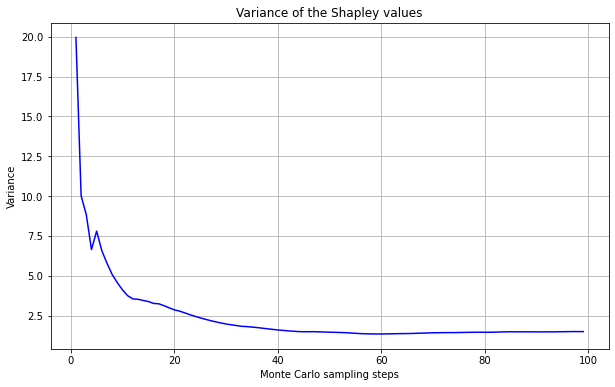

Atom "[C@H]" contains stereochemical information that will be discarded.


Using P: 0.5


  0%|          | 0/21 [00:00<?, ?it/s]

['Cc1ccc2nccc(C(=O)N3CCC[C@H](C(=O)c4cccc5ccccc45)C3)c2c1']
V j plus hausdorff batches per atom: [[2.127795933731204, 5.556375423248093, 2.287302601225135, 8.366230811405153, 4.802368350295671, 5.345256610666098, 8.067775183636858, 5.480115827067127, 2.2719459203600367, 3.0279656408010918, 2.6411649903357755, 3.061598594771681, 3.12651529744585, 2.1423436894468204, 2.6372097937305754, 3.853651298663978, 3.254210183376539, 3.139560549671149, 3.288575638263101, 7.385339905126581, 3.3198217183717826, 1.395604498154336, 3.346171420495922, 2.6332115679878165, 6.705360449325888, 2.392945628637893, 3.0661122240772785, 3.417928161005768, 2.5744025455172697, 2.9991350410674755, 2.89743949424772, 5.831554551752658, 4.186917519739349, 2.1234372891086535, 2.9625464021503807, 2.811716446528174, 1.9737892178740646, 5.016628543263021, 7.950004214117879, 3.3298494895094013, 4.94111598670002, 6.661252007414725, 5.972552685571747, 2.9071528833504887, 5.294402021981381, 8.17019812102806, 6.95666387372418

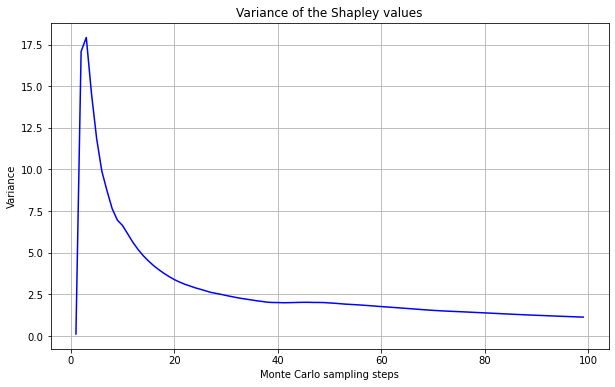

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.


Using P: 0.5


  0%|          | 0/22 [00:00<?, ?it/s]

['C[C@H]1C[C@@H](C)CN(S(=O)(=O)c2ccc(NC(=O)c3cccs3)cc2)C1']
V j plus hausdorff batches per atom: [[0.40918492707822834, 7.013839783910987, 0.9975052026503771, 0.6288658114223796, 0.857984399270375, 1.6720636962369655, 1.9395556266222151, 0.4988793323471654, 5.413717957240974, 2.4871297991884047, 0.38157146049184926, 0.640926937798407, 2.0942026211768368, 0.17786517420566483, 2.249957053975015, 0.5350467154639654, 2.2726657570569913, 0.3378572726465276, 2.1959040823634264, 0.7263093320037447, 0.4572067291573103, 3.540082882983585, 0.9816314350857133, 2.0114161318002997, 2.487826408537711, 6.348599980544572, 0.8608342016019073, 0.6463366554982601, 0.6614473055679557, 1.3798133900747513, 0.804598452747017, 0.88336380529406, 4.830430581785407, 7.733744126938575, 0.39009061138006473, 0.14759768174527993, 2.8455545647144307, 0.4434172178478741, 2.5032076998018447, 4.479602992836822, 6.621280972984181, 2.5003898502353077, 2.1724605884522874, 7.112709940264276, 1.7756555803106973, 1.0764727667

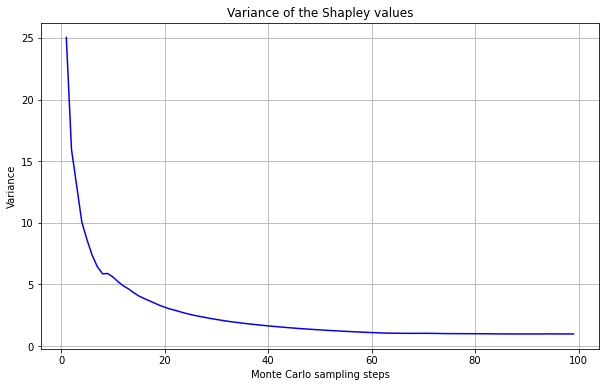

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.


Using P: 0.5


  0%|          | 0/19 [00:00<?, ?it/s]

['C[C@H]1C[C@@H](C)CN(S(=O)(=O)c2ccc(NC(=O)c3cccs3)cc2)C1']
V j plus hausdorff batches per atom: [[2.415822696684532, 2.1171948644451555, 0.6500386181664919, 1.1467612324554985, 1.9217480009493895, 1.6682906922872227, 1.7774371304085876, 1.4377497040365834, 2.1634658195269822, 1.4398661202167597, 1.5513480837128415, 1.8987322502549877, 1.4388567399336647, 1.4699042834852678, 1.227544614325261, 1.5033813119014037, 4.2673327435973665, 1.6872167584711164, 1.7243468685178398, 1.4676123160042827, 1.0828060775796866, 2.2140215512618804, 1.4651171474764524, 1.3920496564338782, 1.4091854766528515, 0.8027538161527399, 1.672543616471951, 1.8052617748405613, 0.5005493911567775, 1.275068028803139, 2.1550643470771953, 1.5795087271209096, 2.044700254114649, 0.5438222949438446, 1.4719916595977038, 1.5926235535588094, 1.4648382733065732, 1.4664067982396973, 3.2627153540388956, 1.4928798482536745, 2.0681086231898633, 2.1369987174796563, 3.2332761273069766, 1.572411694640034, 2.0005840518181572, 1.45661

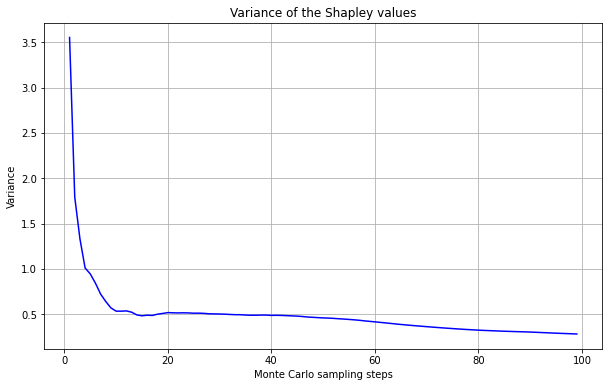

Using P: 0.5


  0%|          | 0/29 [00:00<?, ?it/s]

['Cc1nc(C(F)(F)F)ccc1C(=O)N1CCC(C(=O)Nc2ccc(S(N)(=O)=O)cc2)CC1']
V j plus hausdorff batches per atom: [[2.4802212438666125, 0.19832429000607835, 1.7142728989846165, 6.042455737206784, 0.06655822889844674, 1.306962698034885, 1.4267251103429546, 3.778383457577185, 2.682796655795568, 2.5511159793317155, 2.2851807305269194, 1.4268377986195333, 2.5300395069782757, 0.12246153991520096, 1.706651620395899, 1.419134939397368, 2.2955836333722766, 1.7693264962493862, 1.7787055765993347, 1.7294760105319937, 0.12484308887481335, 0.26016756016176223, 1.7526359213371532, 0.29403836063059413, 1.5851773916852, 1.4721257047867014, 4.677365217684028, 0.2714481424663098, 1.4614892020060744, 7.132904756723692, 1.353744708271333, 2.1246664329174854, 1.8776177734311754, 4.832680260945072, 2.5936787347263563, 1.8715754859037015, 7.997032215954133, 1.691265924172202, 0.21735586558385436, 2.364649223014543, 7.461082556258244, 1.6784635904712075, 8.610557170990502, 1.4721608162817537, 1.3284743442427245, 2.42038

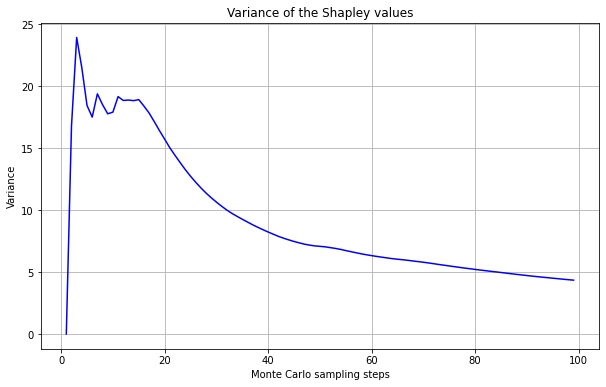

Using P: 0.5


  0%|          | 0/24 [00:00<?, ?it/s]

['Cc1nc(C(F)(F)F)ccc1C(=O)N1CCC(C(=O)Nc2ccc(S(N)(=O)=O)cc2)CC1']
V j plus hausdorff batches per atom: [[1.6144977978202442, 2.5880387956481328, 3.6688333212422704, 3.5464068695774613, 2.466705043887745, 1.7989087206636913, 4.4001566371410705, 5.672579151508409, 2.6168871832904714, 5.692673855291466, 2.4161263749159856, 3.3416374434357525, 1.6604273223689952, 1.6598978198239969, 2.885928675330452, 3.3326060107595907, 2.137533970083633, 3.2885040913221912, 2.755539809506976, 5.251691754832264, 3.2344463214583867, 2.9417822814994548, 5.886258254923006, 2.2236798511064815, 2.3856195453969646, 2.3660752265472644, 3.9422253132184726, 7.074380711354166, 5.95935705458285, 5.696224330545786, 5.2267592765125, 3.8235071054458176, 2.767431913021716, 1.550454360537147, 2.583248767454186, 1.8183587610977212, 2.5616811927184555, 3.7048593861336605, 5.461146851881371, 5.671510417614675, 5.671922824380829, 5.28417031629269, 2.2992891794283157, 2.8168106353050417, 2.5258148082270395, 2.499238929094213, 

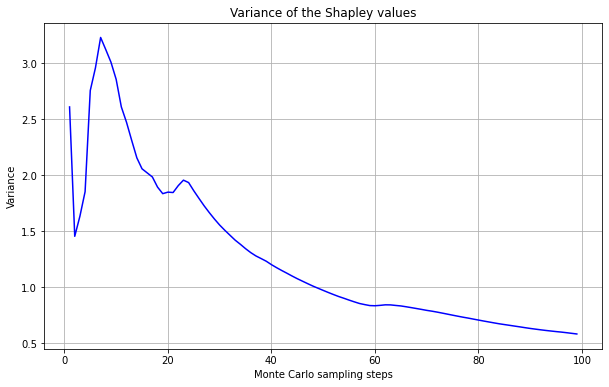

Atom "[C@H]" contains stereochemical information that will be discarded.


Using P: 0.5


  0%|          | 0/19 [00:00<?, ?it/s]

['C[C@H](NC(=O)NCc1cccnc1)c1cccc(OCc2ccccn2)c1']
V j plus hausdorff batches per atom: [[3.0342823717735743, 4.103142292527073, 2.443431264243095, 1.8756741491671145, 2.778994034732129, 2.5129374583662996, 2.8778799056333266, 2.309482280586323, 2.924097862213657, 2.7127595822310258, 2.854753056885561, 2.3370684849841687, 2.8956094823103338, 2.196907734435141, 4.049968174772068, 2.168853057916608, 3.406160088351181, 2.035888619580679, 2.1518965106615107, 2.2348036701045015, 2.354037532801101, 3.2115842891872495, 1.4344740009186991, 1.9986710235362257, 2.253684129911373, 2.505013193048626, 4.275169071750747, 4.495497081465863, 1.7318777124573428, 4.04542441110558, 2.9904894882113817, 1.9824202994043116, 3.6881378442773283, 2.1551349407302705, 2.352439191805609, 3.8958384328678726, 3.2400585579750323, 2.261285880044506, 6.5574808483536735, 2.3383621181291794, 2.018430903480355, 6.264661328897673, 3.5131618937768896, 2.2579113926274186, 2.2143477081343765, 4.191136781056821, 2.8834563913431

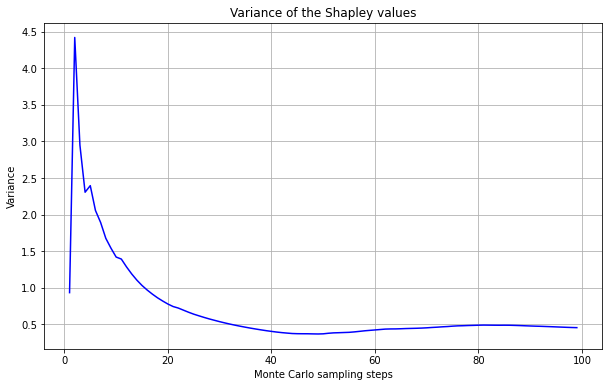

Atom "[C@H]" contains stereochemical information that will be discarded.


Using P: 0.5


  0%|          | 0/21 [00:00<?, ?it/s]

['C[C@H](NC(=O)NCc1cccnc1)c1cccc(OCc2ccccn2)c1']
V j plus hausdorff batches per atom: [[2.234465695254159, 6.970549857276979, 2.420985835964782, 1.8462645701826084, 2.049906359334695, 5.832111275834259, 2.241096495847095, 3.395855759280314, 1.689029813266165, 1.6873490124419792, 1.7295160625328048, 3.5132602689667283, 2.3946692262735483, 2.4612444692487245, 3.7731918798673254, 2.154700623581843, 1.4505371254391208, 6.872125377652891, 6.3870723335301545, 2.3426134715999893, 1.4949394842481014, 1.876507026605441, 3.5879238090306425, 2.0343230930194713, 1.6889194764785098, 1.7540499835356862, 1.6646002736364895, 1.8598592801174263, 1.8032098585352963, 1.8094548585787682, 1.814937593364289, 2.5420513461854313, 1.7982908919081353, 1.7745992088737161, 1.7420670700882326, 1.8447965962269428, 1.8920207641234934, 2.529215061024456, 1.9079283546942927, 2.8488566734667287, 3.032624478492917, 3.060852623196037, 2.406477146194196, 1.6823362243974045, 3.1921079038742306, 3.5579612346181677, 2.385442

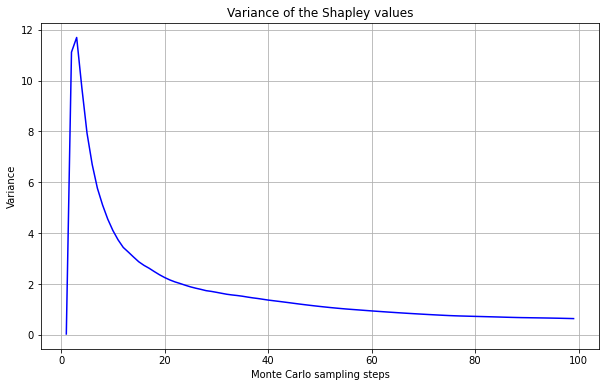

In [6]:
torch.set_printoptions(threshold=float('inf'))

num_samples = NUM_SAMPLES
sampled = 0
start = 0

chain_with_full_fragments = None

# Create the folder if it does not exist

folder_save_path = f"results/plots/variance_study_{P}_seed_{SEED}_{transformations_str}_transformation_seed_{TRANSFORMATION_SEED}_COM_addition"

if not os.path.exists(folder_save_path):
    os.makedirs(folder_save_path)

data_list = []
for data in dataloader:

    if sampled < num_samples:
        data_list.append(data)
        sampled += 1

#determine max numebr of atoms of the molecules in the dataset. This is used to determine the size of the random noise, which we want to be equal for all molecules -> atoms not present in the molecule will be discarded using masks 
max_num_atoms = max(data["positions"].shape[1] for data in data_list)


pos_size = (data_list[0]["positions"].shape[0], max_num_atoms, data_list[0]["positions"].shape[2])
feature_size = (data_list[0]["one_hot"].shape[0], max_num_atoms, data_list[0]["one_hot"].shape[2])

INTIAL_DISTIBUTION_PATH = "initial_distributions/seed_" + str(SEED)
noisy_features = None
noisy_positions = None
#check if the initial distribution of the noisy features and positions already exists, if not create it
if os.path.exists(INTIAL_DISTIBUTION_PATH + "/noisy_features_seed_" + str(SEED) + ".pt"):
    # load initial distrubution of noisy features and positions
    print("Loading initial distribution of noisy features and positions.")
    noisy_features = torch.load(INTIAL_DISTIBUTION_PATH + "/noisy_features_seed_" + str(SEED) + ".pt", map_location=device, weights_only=True)
    noisy_positions = torch.load(INTIAL_DISTIBUTION_PATH + "/noisy_positions_seed_" + str(SEED) + ".pt", map_location=device, weights_only=True)

else:
    print("Creating initial distribution of noisy features and positions.")
    noisy_positions = torch.randn(pos_size, device=device)
    noisy_features = torch.randn(feature_size, device=device)


    #save the noisy positions and features on file .txt
    print("Saving noisy features and positions to .txt and .pt files.")
    noisy_positions_file = os.path.join(folder_save_path, "noisy_positions_seed_" + str(SEED) + ".txt")
    noisy_features_file = os.path.join(folder_save_path, "noisy_features_seed_" + str(SEED) + ".txt")

    with open(noisy_positions_file, "w") as f:
        f.write(str(noisy_positions))

    with open(noisy_features_file, "w") as f:
        f.write(str(noisy_features))

    torch.save(noisy_positions, os.path.join(folder_save_path, "noisy_positions_seed_" + str(SEED) + ".pt"))
    torch.save(noisy_features, os.path.join(folder_save_path, "noisy_features_seed_" + str(SEED) + ".pt"))

for data_index, data in enumerate(tqdm(data_list)): #7:

       
        
        smile = data["name"][0]
        
        mol = read_smiles(smile)
        num_nodes = mol.number_of_nodes()
        
        num_edges = mol.number_of_edges()
        num_edges_directed = num_edges*2
        
        
        graph_density = num_edges_directed/(num_nodes*(num_nodes-1))
        max_number_of_nodes = num_edges + 1

        node_density = num_nodes/max_number_of_nodes

        node_edge_ratio = num_nodes/num_edges
        
        edge_node_ratio = num_edges/num_nodes
        
        if P == "graph_density":
            P = graph_density #probability of atom to exist in random graph (not sure if correct approach, this was correct for edges)
        elif P == "node_density":
            P = node_density
        elif P == "node_edge_ratio" or P == "edge_node_ratio":
            if node_edge_ratio < edge_node_ratio:
                P = node_edge_ratio
                print("Using node-edge ratio", node_edge_ratio)
            else:
                P = edge_node_ratio
                print("Using edge-node ratio", edge_node_ratio)            
        else:
            try:
                P = float(P)
            except ValueError:
                raise ValueError("P must be either 'graph_density', 'node_density', 'node_edge_ratio', 'edge_node_ratio' or a float value.")
        

        print("Using P:", P)

        chain_with_full_fragments = None
       
        rng = default_rng(seed = SEED)
        rng_torch = torch.Generator(device="cpu")
        rng_torch.manual_seed(SEED)

        #apply E(3) trasformations to the molecule. Linker atoms will be tranformed, too, but their transformations will be discarded in liue of the noisy positions
        
        transform_rng = None
        if transformations:
            transform_rng = default_rng(seed = TRANSFORMATION_SEED)
            
        if ROTATE:
            #rotate molecule
            # Generate a random 3x3 matrix
            random_matrix = torch.tensor(transform_rng.uniform(-1, 1, (3, 3)), device=device, dtype=torch.float32)
            
            # Perform QR decomposition to obtain an orthogonal matrix
            q, r = torch.linalg.qr(random_matrix)
            
            # Ensure the determinant is 1 (if not, adjust it)
            if torch.det(q) < 0:
                q[:, 0] = -q[:, 0]
            
            #ensure q has float values
            # q = q.float()
            # Apply the rotation matrix to the molecule positions
            data["positions"] = torch.matmul(data["positions"], q)
        if TRANSLATE:
            #translate molecule
            translation_vector = torch.tensor(transform_rng.uniform(-1, 1, (1, 3)), device=device, dtype=torch.float32)
            data["positions"] = data["positions"] + translation_vector
        if REFLECT:
            #reflect molecule acrpss the xy plane
            reflection_matrix = torch.tensor([[1.0, 0.0, 0.0],
                                      [0.0, 1.0, 0.0],
                                      [0.0, 0.0, -1.0]], device=device)
            data["positions"] = torch.matmul(data["positions"], reflection_matrix)
            

        
        
        #filter the noisy positions and features to have the same size as the data, removing the atoms not actually present in the molecule
        #we use the same max sized noise for all molecules to guaranteethat the same moleclues are inzialized with the same noise for the linker atoms in common -> noise for the fragme atoms will be discarded
        noisy_positions_present_atoms = noisy_positions.clone()
        noisy_features_present_atoms = noisy_features.clone()

        noisy_positions_present_atoms = noisy_positions_present_atoms[:, :data["positions"].shape[1], :]
        noisy_features_present_atoms = noisy_features_present_atoms[:, :data["one_hot"].shape[1], :]

        # print("Filtered noisy positions:", noisy_positions_present_atoms)
        # print("Filtered noisy features:", noisy_positions_present_atoms)    

        chain_batch, node_mask = model.sample_chain(data, keep_frames=keep_frames, noisy_positions=noisy_positions_present_atoms, noisy_features=noisy_features_present_atoms)
        
        #get the generated molecule and store it in a variable
        chain_with_full_fragments = chain_batch[0, :, :, :] #need to get only the final frame, is 0 ok in the first dimension?
        
        # # Compute distance of two chains
        
        # #compute molecular distance using batches
        original_linker_mask_batch = data["linker_mask"][0].squeeze().repeat(PARALLEL_STEPS, 1) #check why it works
        
        original_positions = data["positions"][0]
        chain_positions = chain_with_full_fragments[0, :, :3]
        # print("Original positions: ", original_positions)
        # print("Chain positions: ", chain_positions)

        position_differences = original_positions - chain_positions
        position_differences = position_differences[data["fragment_mask"].squeeze().bool()][0]
        chain_with_full_fragments[:, :, :3] = chain_with_full_fragments[:, :, :3] + position_differences
        
        #adding offset to the rest of the frames
        for i in range(1, keep_frames):
            chain_batch[i, :, :, :3] = chain_batch[i, :, :, :3] + position_differences
        
        
        num_fragment_atoms = torch.sum(data["fragment_mask"] == 1)

        phi_atoms = {}
        
        num_atoms = data["positions"].shape[1]
        num_linker_atoms = torch.sum(data["linker_mask"] == 1)
        
        distances_random_samples = []
        cosine_similarities_random_samples = []
        hausdorff_distances_random_samples = []

        V_j_plus_hausdorff_batches_per_atom = []
        V_j_minus_hausdorff_batches_per_atom = []
        V_random_hausdorff_batches_per_atom = []

        # Fill V_j_plus_hausdorff_batches_per_atom with 1000 random values for each atom UNCOMMENT FOR DEBUGGING PURPOSES
        # for atom_index in range(num_fragment_atoms):
        #     random_values_plus = torch.rand(1000).tolist()  # Generate 1000 random values
        #     V_j_plus_hausdorff_batches_per_atom.append(random_values_plus)
        #     random_values_minus = torch.rand(1000).tolist()  # Generate 1000 random values
        #     V_j_minus_hausdorff_batches_per_atom.append(random_values_minus)
        #     random_values = torch.rand(1000).tolist()  # Generate 1000 random values
        #     V_random_hausdorff_batches_per_atom.append(random_values)

        #UNCOMMENT FOR ACTUAL PHI COMPUTATION
        for j in tqdm(range(num_fragment_atoms)):

            marginal_contrib_distance = 0
            marginal_contrib_cosine_similarity = 0
            marginal_contrib_hausdorff = 0

            
            for step in range(int(M/PARALLEL_STEPS)):
                # start_time = time.time()

                fragment_indices = torch.where(data["fragment_mask"] == 1)[1]
                num_fragment_atoms = len(fragment_indices)
                fragment_indices = fragment_indices.repeat(PARALLEL_STEPS).to(device)


                N_z_mask = torch.tensor(np.array([rng.binomial(1, P, size = num_fragment_atoms) for _ in range(PARALLEL_STEPS)]), dtype=torch.int32)
                # Ensure at least one element is 1, otherwise randomly select one since at least one fragment atom must be present
                
                
                for i in range(len(N_z_mask)):

                    #set the current explained atom to 0 in N_z_mask
                    N_z_mask[i][j] = 0 #so it is always one when taken from the oriignal sample and 0 when taken from the random sample. 

                    if not N_z_mask[i].any():
                        
                        random_index = j #j is the current explained atom, it should always be set to 0
                        while random_index == j:
                            random_index = rng.integers(0, num_fragment_atoms)
                        N_z_mask[i][random_index] = 1
                        # print("Random index", random_index)
                        # print("j", j)
                       
                    

                N_z_mask=N_z_mask.flatten().to(device)
                
                N_mask = torch.ones(PARALLEL_STEPS * num_fragment_atoms, dtype=torch.int32, device=device)

                pi = torch.cat([torch.randperm(num_fragment_atoms, generator=rng_torch) for _ in range(PARALLEL_STEPS)], dim=0)

                N_j_plus_index = torch.ones(PARALLEL_STEPS*num_fragment_atoms, dtype=torch.int, device=device)
                N_j_minus_index = torch.ones(PARALLEL_STEPS*num_fragment_atoms, dtype=torch.int, device=device)

                selected_node_index = np.where(pi == j)
                selected_node_index = torch.tensor(np.array(selected_node_index), device=device).squeeze()
                selected_node_index = selected_node_index.repeat_interleave(num_fragment_atoms) 
                k_values = torch.arange(num_fragment_atoms*PARALLEL_STEPS, device=device)

                add_to_pi = torch.arange(start=0, end=PARALLEL_STEPS*num_fragment_atoms, step=num_fragment_atoms).repeat_interleave(num_fragment_atoms)

                pi_add = pi + add_to_pi
                pi_add = pi_add.to(device=device)
                
                add_to_node_index = torch.arange(start=0, end=PARALLEL_STEPS*num_atoms, step=num_atoms) 
                
                add_to_node_index = add_to_node_index.repeat_interleave(num_fragment_atoms).to(device) 

                
                N_j_plus_index[pi_add] = torch.where(k_values <= selected_node_index, N_mask[pi_add], N_z_mask[pi_add])
                N_j_minus_index[pi_add] = torch.where(k_values < selected_node_index, N_mask[pi_add], N_z_mask[pi_add]) 

                #fragements to keep in molecule j plus
                fragment_indices = fragment_indices + add_to_node_index
                
                
                N_j_plus = fragment_indices[(N_j_plus_index==1)] #fragment to keep in molecule j plus
                #fragement indices to keep in molecule j minus
               
                N_j_minus = fragment_indices[(N_j_minus_index==1)] 

                #fragement indices to keep in random molecule
                N_random_sample = fragment_indices[(N_z_mask==1)] 
                
                # print("N random sample", N_random_sample)
                atom_mask_j_plus = torch.zeros(num_atoms*PARALLEL_STEPS, dtype=torch.bool)
                atom_mask_j_minus = torch.zeros(num_atoms*PARALLEL_STEPS, dtype=torch.bool)
                atom_mask_random_molecule = torch.zeros(num_atoms*PARALLEL_STEPS, dtype=torch.bool)

                atom_mask_j_plus[N_j_plus] = True
                
                atom_mask_j_minus[N_j_minus] = True

                #set to true also linker atoms
                parallelized_linker_mask = data["linker_mask"][0].squeeze().to(torch.int).repeat(PARALLEL_STEPS)
                atom_mask_j_plus[(parallelized_linker_mask == 1)] = True 

                #set to true also linker atoms
                atom_mask_j_minus[(parallelized_linker_mask == 1)] = True 

                atom_mask_random_molecule[N_random_sample] = True
                #set to true also linker atoms
                atom_mask_random_molecule[(parallelized_linker_mask == 1)] = True
                
               
                atom_mask_j_plus = atom_mask_j_plus.view(PARALLEL_STEPS, num_atoms)
                atom_mask_j_minus = atom_mask_j_minus.view(PARALLEL_STEPS, num_atoms)
                atom_mask_random_molecule = atom_mask_random_molecule.view(PARALLEL_STEPS, num_atoms)

                data_j_plus_dict = {}
                data_j_minus_dict = {}
                data_random_dict = {}

                noisy_features_j_plus_dict = {}
                noisy_positions_j_plus_dict = {}
                noisy_features_j_minus_dict = {}
                noisy_positions_j_minus_dict = {}
                noisy_features_random_dict = {}
                noisy_positions_random_dict = {}
                
                # start_time = time.time()
                for i in range(PARALLEL_STEPS):

                    # Remove fragment atoms that are not present for j plus
                    noisy_features_present_atoms_j_plus = noisy_features_present_atoms.clone()
                    noisy_features_j_plus_dict[i] = noisy_features_present_atoms_j_plus[:, atom_mask_j_plus[i], :]
                    
                    noisy_positions_present_atoms_j_plus = noisy_positions_present_atoms.clone()
                    noisy_positions_j_plus_dict[i] = noisy_positions_present_atoms_j_plus[:, atom_mask_j_plus[i], :]

                    # Remove fragment atoms that are not present for j minus
                    noisy_features_present_atoms_j_minus = noisy_features_present_atoms.clone()
                    noisy_features_j_minus_dict[i] = noisy_features_present_atoms_j_minus[:, atom_mask_j_minus[i], :]

                    noisy_positions_present_atoms_j_minus = noisy_positions_present_atoms.clone()
                    noisy_positions_j_minus_dict[i] = noisy_positions_present_atoms_j_minus[:, atom_mask_j_minus[i], :]

                    # Remove fragment atoms that are not present for random molecule
                    noisy_features_present_atoms_random = noisy_features_present_atoms.clone()
                    noisy_features_random_dict[i] = noisy_features_present_atoms_random[:, atom_mask_random_molecule[i], :]

                    noisy_positions_present_atoms_random = noisy_positions_present_atoms.clone()
                    noisy_positions_random_dict[i] = noisy_positions_present_atoms_random[:, atom_mask_random_molecule[i], :]

                    data_j_plus_dict[i] = copy.deepcopy(data)
                    data_j_minus_dict[i] = copy.deepcopy(data)
                    data_random_dict[i] = copy.deepcopy(data)

                    #data j plus
                    data_j_plus_dict[i]["positions"] = data_j_plus_dict[i]["positions"][:, atom_mask_j_plus[i]]
                    data_j_plus_dict[i]["num_atoms"] = data_j_plus_dict[i]["positions"].shape[1]
                    # remove one_hot of atoms in random_indices
                    data_j_plus_dict[i]["one_hot"] = data_j_plus_dict[i]["one_hot"][:, atom_mask_j_plus[i]]
                    # remove atom_mask of atoms in random_indices
                    data_j_plus_dict[i]["atom_mask"] = data_j_plus_dict[i]["atom_mask"][:, atom_mask_j_plus[i]]
                    # remove fragment_mask of atoms in random_indices
                    data_j_plus_dict[i]["fragment_mask"] = data_j_plus_dict[i]["fragment_mask"][:, atom_mask_j_plus[i]]
                    # remove linker_mask of atoms in random_indices
                    data_j_plus_dict[i]["linker_mask"] = data_j_plus_dict[i]["linker_mask"][:, atom_mask_j_plus[i]]
                    data_j_plus_dict[i]["charges"] = data_j_plus_dict[i]["charges"][:, atom_mask_j_plus[i]]
                    data_j_plus_dict[i]["anchors"] = data_j_plus_dict[i]["anchors"][:, atom_mask_j_plus[i]]
                    edge_mask_to_keep = (atom_mask_j_plus[i].unsqueeze(1) * atom_mask_j_plus[i]).flatten()
                    data_j_plus_dict[i]["edge_mask"] = data_j_plus_dict[i]["edge_mask"][edge_mask_to_keep]

                    #data j minus
                    data_j_minus_dict[i]["positions"] = data_j_minus_dict[i]["positions"][:, atom_mask_j_minus[i]]
                    data_j_minus_dict[i]["num_atoms"] = data_j_minus_dict[i]["positions"].shape[1]
                    # remove one_hot of atoms in random_indices
                    data_j_minus_dict[i]["one_hot"] = data_j_minus_dict[i]["one_hot"][:, atom_mask_j_minus[i]]
                    # remove atom_mask of atoms in random_indices
                    data_j_minus_dict[i]["atom_mask"] = data_j_minus_dict[i]["atom_mask"][:, atom_mask_j_minus[i]]
                    # remove fragment_mask of atoms in random_indices
                    data_j_minus_dict[i]["fragment_mask"] = data_j_minus_dict[i]["fragment_mask"][:, atom_mask_j_minus[i]]
                    # remove linker_mask of atoms in random_indices
                    data_j_minus_dict[i]["linker_mask"] = data_j_minus_dict[i]["linker_mask"][:, atom_mask_j_minus[i]]
                    data_j_minus_dict[i]["charges"] = data_j_minus_dict[i]["charges"][:, atom_mask_j_minus[i]]
                    data_j_minus_dict[i]["anchors"] = data_j_minus_dict[i]["anchors"][:, atom_mask_j_minus[i]]
                    # remove edge_mask of atoms in random_indices
                    edge_mask_to_keep = (atom_mask_j_minus[i].unsqueeze(1) * atom_mask_j_minus[i]).flatten() 
                    data_j_minus_dict[i]["edge_mask"] = data_j_minus_dict[i]["edge_mask"][edge_mask_to_keep]

                    #data random
                    data_random_dict[i]["positions"] = data_random_dict[i]["positions"][:, atom_mask_random_molecule[i]]
                    data_random_dict[i]["num_atoms"] = data_random_dict[i]["positions"].shape[1]
                    # remove one_hot of atoms in random_indices
                    data_random_dict[i]["one_hot"] = data_random_dict[i]["one_hot"][:, atom_mask_random_molecule[i]]
                    # remove atom_mask of atoms in random_indices
                    data_random_dict[i]["atom_mask"] = data_random_dict[i]["atom_mask"][:, atom_mask_random_molecule[i]]
                    # remove fragment_mask of atoms in random_indices
                    data_random_dict[i]["fragment_mask"] = data_random_dict[i]["fragment_mask"][:, atom_mask_random_molecule[i]]
                    # remove linker_mask of atoms in random_indices
                    data_random_dict[i]["linker_mask"] = data_random_dict[i]["linker_mask"][:, atom_mask_random_molecule[i]]
                    data_random_dict[i]["charges"] = data_random_dict[i]["charges"][:, atom_mask_random_molecule[i]]
                    data_random_dict[i]["anchors"] = data_random_dict[i]["anchors"][:, atom_mask_random_molecule[i]]
                    # remove edge_mask of atoms in random_indices
                    # remove edge_mask of atoms in random_indices
                    edge_mask_to_keep = (atom_mask_random_molecule[i].unsqueeze(1) * atom_mask_random_molecule[i]).flatten() 

                    data_random_dict[i]["edge_mask"] = data_random_dict[i]["edge_mask"][edge_mask_to_keep]
                
                # end_time = time.time()
                # print("Time to remove atoms from molecules in seconds:", end_time - start_time)

                PADDING = True

                # start_time = time.time()
                if PADDING:

                    max_atoms_j_plus = max(data_j_plus_dict[i]["num_atoms"] for i in range(PARALLEL_STEPS))

                    max_edges_j_plus = max(data_j_plus_dict[i]["edge_mask"].shape[0] for i in range(PARALLEL_STEPS))
                    
                    
                    max_atoms_j_minus = max(data_j_minus_dict[i]["num_atoms"] for i in range(PARALLEL_STEPS))

                    max_edges_j_minus = max(data_j_minus_dict[i]["edge_mask"].shape[0] for i in range(PARALLEL_STEPS))

                    max_atoms_random = max(data_random_dict[i]["num_atoms"] for i in range(PARALLEL_STEPS))

                    max_edges_random = max(data_random_dict[i]["edge_mask"].shape[0] for i in range(PARALLEL_STEPS))
                    
                    for i in range(PARALLEL_STEPS):
                        #for j plus positions
                        num_atoms_to_stack = max_atoms_j_plus - data_j_plus_dict[i]["positions"].shape[1]
                        padding = torch.zeros(data_j_plus_dict[i]["positions"].shape[0], num_atoms_to_stack, data_j_plus_dict[i]["positions"].shape[2]).to(device)
                        stacked_positions = torch.cat((data_j_plus_dict[i]["positions"], padding), dim=1)
                        data_j_plus_dict[i]["positions"] = stacked_positions
                        #for j plus one_hot
                        padding = torch.zeros(data_j_plus_dict[i]["one_hot"].shape[0], num_atoms_to_stack, data_j_plus_dict[i]["one_hot"].shape[2]).to(device)
                        stacked_one_hot = torch.cat((data_j_plus_dict[i]["one_hot"], padding), dim=1)
                        data_j_plus_dict[i]["one_hot"] = stacked_one_hot
                        padding = torch.zeros(data_j_plus_dict[i]["fragment_mask"].shape[0], num_atoms_to_stack, data_j_plus_dict[i]["fragment_mask"].shape[2]).to(device)
                        stacked_fragment_mask = torch.cat((data_j_plus_dict[i]["fragment_mask"], padding), dim=1)
                        data_j_plus_dict[i]["fragment_mask"] = stacked_fragment_mask
                        padding = torch.zeros(data_j_plus_dict[i]["charges"].shape[0], num_atoms_to_stack, data_j_plus_dict[i]["charges"].shape[2]).to(device)
                        stacked_charges = torch.cat((data_j_plus_dict[i]["charges"], padding), dim=1)
                        data_j_plus_dict[i]["charges"] = stacked_charges
                        padding = torch.zeros(data_j_plus_dict[i]["anchors"].shape[0], num_atoms_to_stack, data_j_plus_dict[i]["anchors"].shape[2]).to(device)
                        stacked_anchors = torch.cat((data_j_plus_dict[i]["anchors"], padding), dim=1)
                        data_j_plus_dict[i]["anchors"] = stacked_anchors
                        padding = torch.zeros(data_j_plus_dict[i]["linker_mask"].shape[0], num_atoms_to_stack, data_j_plus_dict[i]["linker_mask"].shape[2]).to(device)
                        stacked_linker_mask = torch.cat((data_j_plus_dict[i]["linker_mask"], padding), dim=1)
                        data_j_plus_dict[i]["linker_mask"] = stacked_linker_mask
                        padding = torch.zeros(data_j_plus_dict[i]["atom_mask"].shape[0], num_atoms_to_stack, data_j_plus_dict[i]["atom_mask"].shape[2]).to(device)
                        stacked_atom_mask = torch.cat((data_j_plus_dict[i]["atom_mask"], padding), dim=1)
                        data_j_plus_dict[i]["atom_mask"] = stacked_atom_mask
                        num_edges_to_stack = max_edges_j_plus - data_j_plus_dict[i]["edge_mask"].shape[0]
                        data_j_plus_dict[i]["edge_mask"] = data_j_plus_dict[i]["edge_mask"].unsqueeze(0)
                        padding = torch.zeros(data_j_plus_dict[i]["edge_mask"].shape[0], num_edges_to_stack, data_j_plus_dict[i]["edge_mask"].shape[2]).to(device)
                        stacked_edge_mask = torch.cat((data_j_plus_dict[i]["edge_mask"], padding), dim=1)
                        data_j_plus_dict[i]["edge_mask"] = stacked_edge_mask
                        
                        #for noisy positions and features for j plus
                        noisy_positions_j_plus_dict[i] = noisy_positions_j_plus_dict[i] #check this
                        padding = torch.zeros(noisy_positions_j_plus_dict[i].shape[0], num_atoms_to_stack, noisy_positions_j_plus_dict[i].shape[2]).to(device)
                        stacked_positions = torch.cat((noisy_positions_j_plus_dict[i], padding), dim=1)
                        noisy_positions_j_plus_dict[i] = stacked_positions

                        noisy_features_j_plus_dict[i] = noisy_features_j_plus_dict[i]
                        padding = torch.zeros(noisy_features_j_plus_dict[i].shape[0], num_atoms_to_stack, noisy_features_j_plus_dict[i].shape[2]).to(device)
                        stacked_features = torch.cat((noisy_features_j_plus_dict[i], padding), dim=1)
                        noisy_features_j_plus_dict[i] = stacked_features

                        #for j minus
                        num_atoms_to_stack = max_atoms_j_minus - data_j_minus_dict[i]["positions"].shape[1]
                        padding = torch.zeros(data_j_minus_dict[i]["positions"].shape[0], num_atoms_to_stack, data_j_minus_dict[i]["positions"].shape[2]).to(device) #why does this work?
                        stacked_positions = torch.cat((data_j_minus_dict[i]["positions"], padding), dim=1)
                        data_j_minus_dict[i]["positions"] = stacked_positions
                        
                        padding = torch.zeros(data_j_minus_dict[i]["one_hot"].shape[0], num_atoms_to_stack, data_j_minus_dict[i]["one_hot"].shape[2]).to(device)
                        stacked_one_hot = torch.cat((data_j_minus_dict[i]["one_hot"], padding), dim=1)
                        data_j_minus_dict[i]["one_hot"] = stacked_one_hot
                        
                        padding = torch.zeros(data_j_minus_dict[i]["fragment_mask"].shape[0], num_atoms_to_stack, data_j_minus_dict[i]["fragment_mask"].shape[2]).to(device)
                        stacked_fragment_mask = torch.cat((data_j_minus_dict[i]["fragment_mask"], padding), dim=1)
                        data_j_minus_dict[i]["fragment_mask"] = stacked_fragment_mask

                        
                        padding = torch.zeros(data_j_minus_dict[i]["charges"].shape[0], num_atoms_to_stack, data_j_minus_dict[i]["charges"].shape[2]).to(device)
                        stacked_charges = torch.cat((data_j_minus_dict[i]["charges"], padding), dim=1)
                        data_j_minus_dict[i]["charges"] = stacked_charges
                        
                        padding = torch.zeros(data_j_minus_dict[i]["anchors"].shape[0], num_atoms_to_stack, data_j_minus_dict[i]["anchors"].shape[2]).to(device)
                        stacked_anchors = torch.cat((data_j_minus_dict[i]["anchors"], padding), dim=1)
                        data_j_minus_dict[i]["anchors"] = stacked_anchors
                       
                        padding = torch.zeros(data_j_minus_dict[i]["linker_mask"].shape[0], num_atoms_to_stack, data_j_minus_dict[i]["linker_mask"].shape[2]).to(device)
                        stacked_linker_mask = torch.cat((data_j_minus_dict[i]["linker_mask"], padding), dim=1)
                        data_j_minus_dict[i]["linker_mask"] = stacked_linker_mask
                        
                        padding = torch.zeros(data_j_minus_dict[i]["atom_mask"].shape[0], num_atoms_to_stack, data_j_minus_dict[i]["atom_mask"].shape[2]).to(device)
                        stacked_atom_mask = torch.cat((data_j_minus_dict[i]["atom_mask"], padding), dim=1)
                        data_j_minus_dict[i]["atom_mask"] = stacked_atom_mask
                        
                        num_edges_to_stack = max_edges_j_minus - data_j_minus_dict[i]["edge_mask"].shape[0]
                        data_j_minus_dict[i]["edge_mask"] = data_j_minus_dict[i]["edge_mask"].unsqueeze(0)
                        padding = torch.zeros(data_j_minus_dict[i]["edge_mask"].shape[0], num_edges_to_stack, data_j_minus_dict[i]["edge_mask"].shape[2]).to(device)
                        stacked_edge_mask = torch.cat((data_j_minus_dict[i]["edge_mask"], padding), dim=1)
                        data_j_minus_dict[i]["edge_mask"] = stacked_edge_mask
                    
                        #for noisy positions and features for j plus
                        noisy_positions_j_minus_dict[i] = noisy_positions_j_minus_dict[i] #check this
                        padding = torch.zeros(noisy_positions_j_minus_dict[i].shape[0], num_atoms_to_stack, noisy_positions_j_minus_dict[i].shape[2]).to(device)
                        stacked_positions = torch.cat((noisy_positions_j_minus_dict[i], padding), dim=1)
                        noisy_positions_j_minus_dict[i] = stacked_positions

                        noisy_features_j_minus_dict[i] = noisy_features_j_minus_dict[i]
                        padding = torch.zeros(noisy_features_j_minus_dict[i].shape[0], num_atoms_to_stack, noisy_features_j_minus_dict[i].shape[2]).to(device)
                        stacked_features = torch.cat((noisy_features_j_minus_dict[i], padding), dim=1)
                        noisy_features_j_minus_dict[i] = stacked_features

                        #for random
                        num_atoms_to_stack = max_atoms_random - data_random_dict[i]["positions"].shape[1]
                        padding = torch.zeros(data_random_dict[i]["positions"].shape[0], num_atoms_to_stack, data_random_dict[i]["positions"].shape[2]).to(device)
                        stacked_positions = torch.cat((data_random_dict[i]["positions"], padding), dim=1)
                        data_random_dict[i]["positions"] = stacked_positions
                        
                        padding = torch.zeros(data_random_dict[i]["one_hot"].shape[0], num_atoms_to_stack, data_random_dict[i]["one_hot"].shape[2]).to(device)
                        stacked_one_hot = torch.cat((data_random_dict[i]["one_hot"], padding), dim=1)
                        data_random_dict[i]["one_hot"] = stacked_one_hot
                        
                        padding = torch.zeros(data_random_dict[i]["fragment_mask"].shape[0], num_atoms_to_stack, data_random_dict[i]["fragment_mask"].shape[2]).to(device)
                        stacked_fragment_mask = torch.cat((data_random_dict[i]["fragment_mask"], padding), dim=1)
                        data_random_dict[i]["fragment_mask"] = stacked_fragment_mask
                        
                        padding = torch.zeros(data_random_dict[i]["linker_mask"].shape[0], num_atoms_to_stack, data_random_dict[i]["linker_mask"].shape[2]).to(device)
                        stacked_linker_mask = torch.cat((data_random_dict[i]["linker_mask"], padding), dim=1)
                        data_random_dict[i]["linker_mask"] = stacked_linker_mask

                       
                        padding = torch.zeros(data_random_dict[i]["charges"].shape[0], num_atoms_to_stack, data_random_dict[i]["charges"].shape[2]).to(device)
                        stacked_charges = torch.cat((data_random_dict[i]["charges"], padding), dim=1)
                        data_random_dict[i]["charges"] = stacked_charges

                    
                        padding = torch.zeros(data_random_dict[i]["anchors"].shape[0], num_atoms_to_stack, data_random_dict[i]["anchors"].shape[2]).to(device)
                        stacked_anchors = torch.cat((data_random_dict[i]["anchors"], padding), dim=1)
                        data_random_dict[i]["anchors"] = stacked_anchors
                       
                        padding = torch.zeros(data_random_dict[i]["atom_mask"].shape[0], num_atoms_to_stack, data_random_dict[i]["atom_mask"].shape[2]).to(device)
                        stacked_atom_mask = torch.cat((data_random_dict[i]["atom_mask"], padding), dim=1)
                        data_random_dict[i]["atom_mask"] = stacked_atom_mask
                        
                        num_edges_to_stack = max_edges_random - data_random_dict[i]["edge_mask"].shape[0]
                        data_random_dict[i]["edge_mask"] = data_random_dict[i]["edge_mask"].unsqueeze(0)
                        padding = torch.zeros(data_random_dict[i]["edge_mask"].shape[0], num_edges_to_stack, data_random_dict[i]["edge_mask"].shape[2]).to(device)
                        stacked_edge_mask = torch.cat((data_random_dict[i]["edge_mask"], padding), dim=1)
                        data_random_dict[i]["edge_mask"] = stacked_edge_mask

                        #for noisy positions and features for j plus
                        noisy_positions_random_dict[i] = noisy_positions_random_dict[i] #check this
                        padding = torch.zeros(noisy_positions_random_dict[i].shape[0], num_atoms_to_stack, noisy_positions_random_dict[i].shape[2]).to(device)
                        stacked_positions = torch.cat((noisy_positions_random_dict[i], padding), dim=1)
                        noisy_positions_random_dict[i] = stacked_positions

                        noisy_features_random_dict[i] = noisy_features_random_dict[i]
                        padding = torch.zeros(noisy_features_random_dict[i].shape[0], num_atoms_to_stack, noisy_features_random_dict[i].shape[2]).to(device)
                        stacked_features = torch.cat((noisy_features_random_dict[i], padding), dim=1)
                        noisy_features_random_dict[i] = stacked_features
                        
                        

                
                #create batch for j plus
                data_j_plus_batch = {}
                data_j_plus_batch["positions"] = torch.stack([data_j_plus_dict[i]["positions"] for i in range(PARALLEL_STEPS)], dim=0).squeeze()
                data_j_plus_batch["one_hot"] = torch.stack([data_j_plus_dict[i]["one_hot"] for i in range(PARALLEL_STEPS)], dim=0).squeeze(1)
                data_j_plus_batch["atom_mask"] = torch.stack([data_j_plus_dict[i]["atom_mask"] for i in range(PARALLEL_STEPS)], dim=0).squeeze(1)
                data_j_plus_batch["fragment_mask"] = torch.stack([data_j_plus_dict[i]["fragment_mask"] for i in range(PARALLEL_STEPS)], dim=0).squeeze(1)
                data_j_plus_batch["linker_mask"] = torch.stack([data_j_plus_dict[i]["linker_mask"] for i in range(PARALLEL_STEPS)], dim=0).squeeze(1)
                data_j_plus_batch["charges"] = torch.stack([data_j_plus_dict[i]["charges"] for i in range(PARALLEL_STEPS)], dim=0).squeeze(1)
                data_j_plus_batch["anchors"] = torch.stack([data_j_plus_dict[i]["anchors"] for i in range(PARALLEL_STEPS)], dim=0).squeeze(1)
                
                
                data_j_plus_batch["uuid"] = [i for i in range(PARALLEL_STEPS)]
                data_j_plus_batch["num_atoms"] = [data_j_plus_dict[i]["num_atoms"] for i in range(PARALLEL_STEPS)]
                data_j_plus_batch["name"] = [data["name"] for _ in range(PARALLEL_STEPS)]
                data_j_plus_batch["edge_mask"] = torch.cat([data_j_plus_dict[i]["edge_mask"] for i in range(PARALLEL_STEPS)], dim=0).squeeze().view(-1).unsqueeze(1)


                #create batch for j minus
                data_j_minus_batch = {}
                data_j_minus_batch["positions"] = torch.stack([data_j_minus_dict[i]["positions"] for i in range(PARALLEL_STEPS)], dim=0).squeeze()
                data_j_minus_batch["one_hot"] = torch.stack([data_j_minus_dict[i]["one_hot"] for i in range(PARALLEL_STEPS)], dim=0).squeeze(1)
                data_j_minus_batch["atom_mask"] = torch.stack([data_j_minus_dict[i]["atom_mask"] for i in range(PARALLEL_STEPS)], dim=0).squeeze(1)
                data_j_minus_batch["fragment_mask"] = torch.stack([data_j_minus_dict[i]["fragment_mask"] for i in range(PARALLEL_STEPS)], dim=0).squeeze(1)
                data_j_minus_batch["linker_mask"] = torch.stack([data_j_minus_dict[i]["linker_mask"] for i in range(PARALLEL_STEPS)], dim=0).squeeze(1)
                data_j_minus_batch["charges"] = torch.stack([data_j_minus_dict[i]["charges"] for i in range(PARALLEL_STEPS)], dim=0).squeeze(1)
                data_j_minus_batch["anchors"] = torch.stack([data_j_minus_dict[i]["anchors"] for i in range(PARALLEL_STEPS)], dim=0).squeeze(1)
                
                data_j_minus_batch["uuid"] = [i for i in range(PARALLEL_STEPS)]
                data_j_minus_batch["num_atoms"] = [data_j_minus_dict[i]["num_atoms"] for i in range(PARALLEL_STEPS)]
                data_j_minus_batch["name"] = [data["name"] for _ in range(PARALLEL_STEPS)]
                data_j_minus_batch["edge_mask"] = torch.cat([data_j_minus_dict[i]["edge_mask"] for i in range(PARALLEL_STEPS)], dim=0).squeeze().view(-1).unsqueeze(1)

                #create batch for random
                data_random_batch = {}
                data_random_batch["positions"] = torch.stack([data_random_dict[i]["positions"] for i in range(PARALLEL_STEPS)], dim=0).squeeze()
                data_random_batch["one_hot"] = torch.stack([data_random_dict[i]["one_hot"] for i in range(PARALLEL_STEPS)], dim=0).squeeze(1)
                data_random_batch["atom_mask"] = torch.stack([data_random_dict[i]["atom_mask"] for i in range(PARALLEL_STEPS)], dim=0).squeeze(1)
                data_random_batch["fragment_mask"] = torch.stack([data_random_dict[i]["fragment_mask"] for i in range(PARALLEL_STEPS)], dim=0).squeeze(1)
                data_random_batch["linker_mask"] = torch.stack([data_random_dict[i]["linker_mask"] for i in range(PARALLEL_STEPS)], dim=0).squeeze(1)
                data_random_batch["charges"] = torch.stack([data_random_dict[i]["charges"] for i in range(PARALLEL_STEPS)], dim=0).squeeze(1)
                data_random_batch["anchors"] = torch.stack([data_random_dict[i]["anchors"] for i in range(PARALLEL_STEPS)], dim=0).squeeze(1)
                
                data_random_batch["uuid"] = [i for i in range(PARALLEL_STEPS)]
                data_random_batch["num_atoms"] = [data_random_dict[i]["num_atoms"] for i in range(PARALLEL_STEPS)]
                data_random_batch["name"] = [data["name"] for _ in range(PARALLEL_STEPS)]
                data_random_batch["edge_mask"] = torch.cat([data_random_dict[i]["edge_mask"] for i in range(PARALLEL_STEPS)], dim=0).squeeze().view(-1).unsqueeze(1)

                
                #create batches for noisy positions and features
                noisy_positions_batch_j_plus = torch.stack([noisy_positions_j_plus_dict[i] for i in range(PARALLEL_STEPS)], dim=0).squeeze()
                noisy_features_batch_j_plus = torch.stack([noisy_features_j_plus_dict[i] for i in range(PARALLEL_STEPS)], dim=0).squeeze()

                noisy_positions_batch_j_minus = torch.stack([noisy_positions_j_minus_dict[i] for i in range(PARALLEL_STEPS)], dim=0).squeeze()
                noisy_features_batch_j_minus = torch.stack([noisy_features_j_minus_dict[i] for i in range(PARALLEL_STEPS)], dim=0).squeeze()

                noisy_positions_batch_random = torch.stack([noisy_positions_random_dict[i] for i in range(PARALLEL_STEPS)], dim=0).squeeze()
                noisy_features_batch_random = torch.stack([noisy_features_random_dict[i] for i in range(PARALLEL_STEPS)], dim=0).squeeze()
                
                
                chain_j_plus_batch, node_mask_j_plus_batch = model.sample_chain(data_j_plus_batch, keep_frames=keep_frames, noisy_positions=noisy_positions_batch_j_plus, noisy_features=noisy_features_batch_j_plus)

                chain_j_plus = chain_j_plus_batch[0, :, :, :] 
                j_plus_original_positions = data_j_plus_batch["positions"].clone()

                chain_j_plus_positions = chain_j_plus[:, :, :3]
                position_differences_j_plus = j_plus_original_positions - chain_j_plus_positions
                

                fragment_and_linker_mask = data_j_plus_batch["fragment_mask"].squeeze().bool() | data_j_plus_batch["linker_mask"].squeeze().bool()
                
                position_differences_j_plus_to_use = torch.zeros((PARALLEL_STEPS, 3), device=device)
                for step in range(PARALLEL_STEPS):
                    position_differences_j_plus_to_use[step, :] = position_differences_j_plus[step][data_j_plus_batch["fragment_mask"].squeeze().bool()[step]][0, :]
                
                
                for step in range(PARALLEL_STEPS):
                    chain_j_plus[step, fragment_and_linker_mask[step], :3] = chain_j_plus[step, fragment_and_linker_mask[step], :3] + position_differences_j_plus_to_use[step]
                
                
                chain_j_minus_batch, node_mask_j_minus_batch = model.sample_chain(data_j_minus_batch, keep_frames=keep_frames, noisy_positions=noisy_positions_batch_j_minus, noisy_features=noisy_features_batch_j_minus)

                chain_j_minus = chain_j_minus_batch[0, :, :, :]

                j_minus_original_positions = data_j_minus_batch["positions"].clone()

                chain_j_minus_positions = chain_j_minus[:, :, :3]
                position_differences_j_minus = j_minus_original_positions - chain_j_minus_positions
                

                fragment_and_linker_mask = data_j_minus_batch["fragment_mask"].squeeze().bool() | data_j_minus_batch["linker_mask"].squeeze().bool()
                
                position_differences_j_minus_to_use = torch.zeros((PARALLEL_STEPS, 3), device=device)
                for step in range(PARALLEL_STEPS):
                    position_differences_j_minus_to_use[step, :] = position_differences_j_minus[step][data_j_minus_batch["fragment_mask"].squeeze().bool()[step]][0, :]
                
                
                for step in range(PARALLEL_STEPS):
                    chain_j_minus[step, fragment_and_linker_mask[step], :3] = chain_j_minus[step, fragment_and_linker_mask[step], :3] + position_differences_j_minus_to_use[step]

                
                chain_random_batch, node_mask_random_batch = model.sample_chain(data_random_batch, keep_frames=keep_frames, noisy_positions=noisy_positions_batch_random, noisy_features=noisy_features_batch_random)

                chain_random = chain_random_batch[0, :, :, :]

                random_original_positions = data_random_batch["positions"].clone()
                
                chain_random_positions = chain_random[:, :, :3]
                position_differences_random = random_original_positions - chain_random_positions
                

                fragment_and_linker_mask = data_random_batch["fragment_mask"].squeeze().bool() | data_random_batch["linker_mask"].squeeze().bool()
                
                position_differences_random_to_use = torch.zeros((PARALLEL_STEPS, 3), device=device)
                for step in range(PARALLEL_STEPS):
                    position_differences_random_to_use[step, :] = position_differences_random[step][data_random_batch["fragment_mask"].squeeze().bool()[step]][0, :]
                
                
                for step in range(PARALLEL_STEPS):
                    chain_random[step, fragment_and_linker_mask[step], :3] = chain_random[step, fragment_and_linker_mask[step], :3] + position_differences_random_to_use[step]
                
                
                chain_with_full_fragments_batch = chain_with_full_fragments.repeat(PARALLEL_STEPS, 1, 1)
    
                
                V_j_plus_hausdorff_batch = compute_hausdorff_distance_batch(chain_with_full_fragments_batch.cpu(), chain_j_plus.cpu(), mask1=original_linker_mask_batch.cpu(), mask2=data_j_plus_batch["linker_mask"].squeeze().cpu())
                
                V_j_plus_hausdorff = sum(V_j_plus_hausdorff_batch)
                V_j_plus_hausdorff_batches_per_atom.append(V_j_plus_hausdorff_batch) #for variance computation

                V_j_minus_hausdorff_batch = compute_hausdorff_distance_batch(chain_with_full_fragments_batch.cpu(), chain_j_minus.cpu(), mask1=original_linker_mask_batch.cpu(), mask2=data_j_minus_batch["linker_mask"].squeeze().cpu())

                V_j_minus_hausdorff = sum(V_j_minus_hausdorff_batch)
                V_j_minus_hausdorff_batches_per_atom.append(V_j_minus_hausdorff_batch) #for variance computation

                V_random_hausdorff_batch = compute_hausdorff_distance_batch(chain_with_full_fragments_batch.cpu(), chain_random.cpu(), mask1=original_linker_mask_batch.cpu(), mask2=data_random_batch["linker_mask"].squeeze().cpu())


                V_random_hausdorff_batches_per_atom.append(V_random_hausdorff_batch) #for variance computation

                for r_haus in V_random_hausdorff_batch:
                    hausdorff_distances_random_samples.append(r_haus)
                

                # marginal_contrib_hausdorff += (V_j_plus_hausdorff - V_j_minus_hausdorff)

                

            # phi_atoms[fragment_indices[j].item()] = [0]    
            # phi_atoms[fragment_indices[j].item()][0] = marginal_contrib_hausdorff/M 

        print(data["name"])

        print("V j plus hausdorff batches per atom:", V_j_plus_hausdorff_batches_per_atom)
        print("len V j plus hausdorff batches per atom:", len(V_j_plus_hausdorff_batches_per_atom))
        print("V j minus hausdorff batches per atom:", V_j_minus_hausdorff_batches_per_atom)
        print("len V j minus hausdorff batches per atom:", len(V_j_minus_hausdorff_batches_per_atom))
        print("V random hausdorff batches per atom:", V_random_hausdorff_batches_per_atom)
        print("len V random hausdorff batches per atom:", len(V_random_hausdorff_batches_per_atom))

        with open(f"results/cumulative_computations/V_j_plus_hausdorff_batches_per_atom_{M}_{data_index}.pkl", "wb") as f:
            pickle.dump(V_j_plus_hausdorff_batches_per_atom, f)
        with open(f"results/cumulative_computations/V_j_minus_hausdorff_batches_per_atom_{M}_{data_index}.pkl", "wb") as f:
            pickle.dump(V_j_minus_hausdorff_batches_per_atom, f)
        with open(f"results/cumulative_computations/V_random_hausdorff_batches_per_atom_{M}_{data_index}.pkl", "wb") as f:
            pickle.dump(V_random_hausdorff_batches_per_atom, f)

        # Compute cumulative sums of the values in V_j_plus_hausdorff_batches_per_atom
        cumulative_sums_j_plus = [0]*len(V_j_plus_hausdorff_batches_per_atom)
        cumulative_sums_j_minus = [0]*len(V_j_plus_hausdorff_batches_per_atom)
        cumulative_sums_random = [0]*len(V_j_plus_hausdorff_batches_per_atom)
        for i in range(len(V_j_plus_hausdorff_batches_per_atom)):
            cumulative_sums_j_plus[i] = []
            for j in range(1, len(V_j_plus_hausdorff_batches_per_atom[i])+1):
                cumulative_sums_j_plus[i].append(sum(V_j_plus_hausdorff_batches_per_atom[i][:j]))
            cumulative_sums_j_minus[i] = []
            for j in range(1, len(V_j_minus_hausdorff_batches_per_atom[i])+1):
                cumulative_sums_j_minus[i].append(sum(V_j_minus_hausdorff_batches_per_atom[i][:j]))
            cumulative_sums_random[i] = []
            for j in range(1, len(V_random_hausdorff_batches_per_atom[i])+1):
                cumulative_sums_random[i].append(sum(V_random_hausdorff_batches_per_atom[i][:j]))
             

        
        # Compute the elementwise differences between V_j_plus_hausdorff_batches_per_atom and V_j_minus_hausdorff_batches_per_atom
        maginal_contributions = [0]*len(cumulative_sums_j_plus)
        for i in range(len(cumulative_sums_j_plus)):
            maginal_contributions[i] = []
            for j in range(len(cumulative_sums_j_plus[i])):
                maginal_contributions[i].append((cumulative_sums_j_plus[i][j] - cumulative_sums_j_minus[i][j])/(j+1))
            
        phi_sums_over_M = [0]*M # sum over the columns
        for i in range(len(maginal_contributions)):
            for j in range(len(maginal_contributions[i])):
                phi_sums_over_M[j] += maginal_contributions[i][j] #TODO check

        #compute the sample variance of phi_sums_over_M and plot the trend with a line plot
        # Compute the sample variance for phi_sums_over_M
        sample_variances = [0] * M
        for i in range(M):
            sample_variances[i] = torch.var(torch.tensor(phi_sums_over_M[:i+1]), unbiased=True).item()
            

        # Plot the sample variance with a line plot
        plt.figure(figsize=(10, 6))
        plt.plot(range(len(sample_variances)), sample_variances, linestyle='-', color='b')
        plt.title('Variance of the Shapley values')
        plt.xlabel('Monte Carlo sampling steps')
        plt.ylabel('Variance')
        # plt.xticks(ticks=range(0, len(sample_variances), 100), labels=[i + 1 for i in range(0, len(sample_variances), 100)]) #TODO start from 1 up to 1000 every 100
        
        plt.grid(True)
        plt.show()

        
       

### Load data and plot variance

/tmp/ipykernel_1453838/1056848901.py:44: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /opt/conda/conda-bld/pytorch_1720538438429/work/aten/src/ATen/native/ReduceOps.cpp:1808.)
  sample_variances[i] = torch.var(torch.tensor(phi_sums_over_M[:i + 1]), unbiased=True).item()


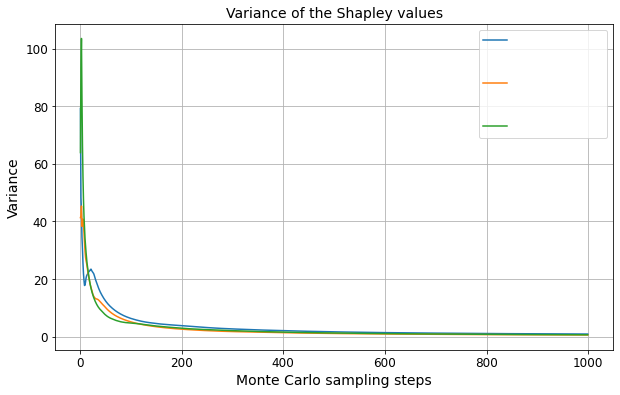

'V_j_plus_hausdorff_batches_per_atom = None\nV_j_minus_hausdorff_batches_per_atom = None\nV_random_hausdorff_batches_per_atom = None\n\nwith open(f"results/cumulative_computations/V_j_plus_hausdorff_batches_per_atom_1000_{data_index}.pkl", "rb") as f:\n    V_j_plus_hausdorff_batches_per_atom = pickle.load(f)\nwith open(f"results/cumulative_computations/V_j_minus_hausdorff_batches_per_atom_1000_{data_index}.pkl", "rb") as f:\n    V_j_minus_hausdorff_batches_per_atom = pickle.load(f)\nwith open(f"results/cumulative_computations/V_random_hausdorff_batches_per_atom_1000_{data_index}.pkl", "rb") as f:\n    V_random_hausdorff_batches_per_atom = pickle.load(f)\n\n# Compute cumulative sums of the values in V_j_plus_hausdorff_batches_per_atom\ncumulative_sums_j_plus = [0]*len(V_j_plus_hausdorff_batches_per_atom)\ncumulative_sums_j_minus = [0]*len(V_j_plus_hausdorff_batches_per_atom)\ncumulative_sums_random = [0]*len(V_j_plus_hausdorff_batches_per_atom)\nfor i in range(len(V_j_plus_hausdorff_bat

In [42]:
M = 1000
data_indices = [0, 1, 4]

all_sample_variances = []

for data_index in data_indices:
    V_j_plus_hausdorff_batches_per_atom = None
    V_j_minus_hausdorff_batches_per_atom = None
    V_random_hausdorff_batches_per_atom = None

    with open(f"results/cumulative_computations/V_j_plus_hausdorff_batches_per_atom_1000_{data_index}.pkl", "rb") as f:
        V_j_plus_hausdorff_batches_per_atom = pickle.load(f)
    with open(f"results/cumulative_computations/V_j_minus_hausdorff_batches_per_atom_1000_{data_index}.pkl", "rb") as f:
        V_j_minus_hausdorff_batches_per_atom = pickle.load(f)
    with open(f"results/cumulative_computations/V_random_hausdorff_batches_per_atom_1000_{data_index}.pkl", "rb") as f:
        V_random_hausdorff_batches_per_atom = pickle.load(f)

    # Compute cumulative sums of the values in V_j_plus_hausdorff_batches_per_atom
    cumulative_sums_j_plus = [0] * len(V_j_plus_hausdorff_batches_per_atom)
    cumulative_sums_j_minus = [0] * len(V_j_plus_hausdorff_batches_per_atom)
    for i in range(len(V_j_plus_hausdorff_batches_per_atom)):
        cumulative_sums_j_plus[i] = []
        for j in range(1, len(V_j_plus_hausdorff_batches_per_atom[i]) + 1):
            cumulative_sums_j_plus[i].append(sum(V_j_plus_hausdorff_batches_per_atom[i][:j]))
        cumulative_sums_j_minus[i] = []
        for j in range(1, len(V_j_minus_hausdorff_batches_per_atom[i]) + 1):
            cumulative_sums_j_minus[i].append(sum(V_j_minus_hausdorff_batches_per_atom[i][:j]))

    # Compute the elementwise differences between V_j_plus_hausdorff_batches_per_atom and V_j_minus_hausdorff_batches_per_atom
    maginal_contributions = [0] * len(cumulative_sums_j_plus)
    for i in range(len(cumulative_sums_j_plus)):
        maginal_contributions[i] = []
        for j in range(len(cumulative_sums_j_plus[i])):
            maginal_contributions[i].append((cumulative_sums_j_plus[i][j] - cumulative_sums_j_minus[i][j]) / (j + 1))

    phi_sums_over_M = [0] * M  # sum over the columns
    for i in range(len(maginal_contributions)):
        for j in range(len(maginal_contributions[i])):
            phi_sums_over_M[j] += maginal_contributions[i][j]

    # Compute the sample variance for phi_sums_over_M
    sample_variances = [0] * M
    for i in range(M):
        sample_variances[i] = torch.var(torch.tensor(phi_sums_over_M[:i + 1]), unbiased=True).item()

    all_sample_variances.append(sample_variances)

# Plot the sample variance for all data indices in a single plot
plt.figure(figsize=(10, 6))
plt.rc('axes', labelsize=14)  # Set font size for axes labels
plt.rc('xtick', labelsize=12)  # Set font size for x-axis ticks
plt.rc('ytick', labelsize=12)  # Set font size for y-axis ticks

for idx, sample_variances in zip(data_indices, all_sample_variances):
    plt.plot(range(len(sample_variances)), sample_variances, label=f"Data Index {idx}")

plt.title('Variance of the Shapley values', fontsize=14)
plt.xlabel('Monte Carlo sampling steps')
plt.ylabel('Variance')
custom_legend_names = ["                      " for idx in data_indices]
plt.legend(custom_legend_names, labelspacing=2.5, loc='upper right', fontsize=12)

plt.grid(True)
plt.savefig(f"results/plots/shapley_value_variance/variance_of_shapley_values_multiple_indices_{M}.png", dpi=300, bbox_inches='tight')
plt.savefig(f"results/plots/shapley_value_variance/variance_of_shapley_values_multiple_indices_{M}.pdf", dpi=300, bbox_inches='tight')
plt.show()

'''V_j_plus_hausdorff_batches_per_atom = None
V_j_minus_hausdorff_batches_per_atom = None
V_random_hausdorff_batches_per_atom = None

with open(f"results/cumulative_computations/V_j_plus_hausdorff_batches_per_atom_1000_{data_index}.pkl", "rb") as f:
    V_j_plus_hausdorff_batches_per_atom = pickle.load(f)
with open(f"results/cumulative_computations/V_j_minus_hausdorff_batches_per_atom_1000_{data_index}.pkl", "rb") as f:
    V_j_minus_hausdorff_batches_per_atom = pickle.load(f)
with open(f"results/cumulative_computations/V_random_hausdorff_batches_per_atom_1000_{data_index}.pkl", "rb") as f:
    V_random_hausdorff_batches_per_atom = pickle.load(f)

# Compute cumulative sums of the values in V_j_plus_hausdorff_batches_per_atom
cumulative_sums_j_plus = [0]*len(V_j_plus_hausdorff_batches_per_atom)
cumulative_sums_j_minus = [0]*len(V_j_plus_hausdorff_batches_per_atom)
cumulative_sums_random = [0]*len(V_j_plus_hausdorff_batches_per_atom)
for i in range(len(V_j_plus_hausdorff_batches_per_atom)):
    cumulative_sums_j_plus[i] = []
    for j in range(1, len(V_j_plus_hausdorff_batches_per_atom[i])+1):
        cumulative_sums_j_plus[i].append(sum(V_j_plus_hausdorff_batches_per_atom[i][:j]))
    cumulative_sums_j_minus[i] = []
    for j in range(1, len(V_j_minus_hausdorff_batches_per_atom[i])+1):
        cumulative_sums_j_minus[i].append(sum(V_j_minus_hausdorff_batches_per_atom[i][:j]))
    cumulative_sums_random[i] = []
    for j in range(1, len(V_random_hausdorff_batches_per_atom[i])+1):
        cumulative_sums_random[i].append(sum(V_random_hausdorff_batches_per_atom[i][:j]))
        


# Compute the elementwise differences between V_j_plus_hausdorff_batches_per_atom and V_j_minus_hausdorff_batches_per_atom
maginal_contributions = [0]*len(cumulative_sums_j_plus)
for i in range(len(cumulative_sums_j_plus)):
    maginal_contributions[i] = []
    for j in range(len(cumulative_sums_j_plus[i])):
        maginal_contributions[i].append((cumulative_sums_j_plus[i][j] - cumulative_sums_j_minus[i][j])/(j+1))
    
phi_sums_over_M = [0]*M # sum over the columns
for i in range(len(maginal_contributions)):
    for j in range(len(maginal_contributions[i])):
        phi_sums_over_M[j] += maginal_contributions[i][j] #TODO check

#compute the sample variance of phi_sums_over_M and plot the trend with a line plot
# Compute the sample variance for phi_sums_over_M
sample_variances = [0] * M
for i in range(M):
    sample_variances[i] = torch.var(torch.tensor(phi_sums_over_M[:i+1]), unbiased=True).item()
    

# Plot the sample variance with a line plot
plt.figure(figsize=(10, 6))
plt.rc('axes', labelsize=14)  # Set font size for axes labels
plt.rc('xtick', labelsize=12)  # Set font size for x-axis ticks
plt.rc('ytick', labelsize=12)  # Set font size for y-axis ticks

plt.plot(range(len(sample_variances)), sample_variances, linestyle='-', color='b')
plt.title('Variance of the Shapley values', fontsize=14)
plt.xlabel('Monte Carlo sampling steps')
plt.ylabel('Variance')
# plt.xticks(ticks=range(0, len(sample_variances), 100), labels=[i + 1 for i in range(0, len(sample_variances), 100)]) #TODO start from 1 up to 1000 every 100

plt.grid(True)
plt.savefig(f"results/plots/shapley_value_variance/variance_of_shapley_values_{M}_{data_index}.png", dpi=300, bbox_inches='tight')
plt.savefig(f"results/plots/shapley_value_variance/variance_of_shapley_values_{M}_{data_index}.pdf", dpi=300, bbox_inches='tight')
plt.show()'''